In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import chi2_contingency, ttest_ind, shapiro
from scipy.stats import mannwhitneyu, kruskal, wilcoxon, kstest
import scikit_posthocs as sp
from scipy.stats import chisquare

In [2]:
from tqdm import tqdm
from scipy.stats import poisson
from matplotlib.patches import Rectangle

### SUM

In [3]:
def calculer_somme (df):
    sommes = []
    colonnes_a_exclure = ['ref_date', 'interval', 'SDATE', 'INTERVAL', 'SUM_CENTS_PRINCIPAL']
    colonnes_numeriques = []
    for col in df.columns:
        if col not in colonnes_a_exclure:
            float(col) 
            colonnes_numeriques.append(col)
            
    df_a_calculer = df[colonnes_numeriques]
    for index, ligne in df_a_calculer.iterrows(): 
        somme_ligne_actuelle = 0
        for nom_colonne, valeur_cellule in ligne.items():            
            valeur_entete = float(nom_colonne)
            valeur_numerique_cellule = float(valeur_cellule)
            somme_ligne_actuelle += valeur_entete * valeur_numerique_cellule
        sommes.append(somme_ligne_actuelle)
    return sommes

### PROVISION

In [4]:
def provision(df_lending, df_recovery):
    sommes_lending = calculer_somme(df_lending)
    sommes_recovery = calculer_somme(df_recovery)
    resultats_finaux = []
    resultat_precedent = 0
    for i in range(len(sommes_lending)):
        difference_ligne_actuelle = sommes_lending[i] - sommes_recovery[i]
        resultat_cumulatif = resultat_precedent + difference_ligne_actuelle
        resultats_finaux.append(resultat_cumulatif)
        resultat_precedent = resultat_cumulatif
    prov = max(resultats_finaux)
    return prov

### MONTECARLO

In [35]:
def montecarlo(df: pd.DataFrame) -> pd.DataFrame:
    n_row = df.shape[0]
    n_col = df.shape[1]
    data_index = df.iloc[:, :2]
    data_value = np.zeros((n_row, n_col - 2))
    intervals = df['INTERVAL'].unique()
    intervals.sort()

    for i in intervals:
        temp = df[df['INTERVAL'] == i]
        temp = temp.iloc[:, 2:]
        lines = [len(intervals) * n + i for n in range(temp.shape[0])]
        for j in range (temp.shape[1]):
            items = temp.iloc[:, j]
            quantile = poisson.ppf(0.975, np.mean(items))
            lambda_hat = np.mean(items)
            values = np.random.poisson (lam = lambda_hat, size = temp.shape[0])
            data_value[lines, j] = values
            
    data_value = pd.DataFrame(data_value, columns=df.columns[2:])
    data_final = pd.concat([data_index, data_value], axis=1) 
        
    return data_final

### BOOTSTRAP

In [36]:
def bootstrap(df: pd.DataFrame) -> pd.DataFrame:
    n_row = df.shape[0]
    n_col = df.shape[1]
    data_index = df.iloc[:, :2]
    data_value = np.zeros((n_row, n_col - 2))
    intervals = df['INTERVAL'].unique()
    intervals.sort()

    for i in intervals:
        temp = df[df['INTERVAL'] == i]
        temp = temp.iloc[:, 2:]
        lines = [len(intervals) * n + i for n in range(temp.shape[0])]
        for j in range (temp.shape[1]):
            items = temp.iloc[:, j]
            values = np.random.choice (items, size = temp.shape[0], replace = True)
            data_value[lines, j] = values
            
    data_value = pd.DataFrame(data_value, columns=df.columns[2:])
    data_final = pd.concat([data_index, data_value], axis=1) 
        
    return data_final

### FINAL FUNCTION

In [207]:
def estimation (file_lending: object, file_recovery: object, alpha = 0.95, N = 10000, method = "Montecarlo"):
    
    lending = pd.read_csv(file_lending, delimiter=';')
    recovery = pd.read_csv(file_recovery, delimiter=';')
    
    list_provision = []
    provisions = provision(lending, recovery)
    list_provision.append(provisions)

    
    if (method == "Montecarlo"):
        for i in tqdm(range(N)):
            temp_lending = montecarlo(lending)
            temp_recovery = montecarlo(recovery)
            provisions = provision(temp_lending, temp_recovery)
            list_provision.append(provisions)
            df_provisions = pd.DataFrame(list_provision, columns=['Montant_Provision_montecarlo'])
            df_provisions.to_csv('provisions_montecarlo.csv', index=False, sep=';')
            

    elif (method == "Bootstrap"):
        for i in tqdm(range(N)):
            temp_lending = bootstrap(lending)
            temp_recovery = bootstrap(recovery)
            provisions = provision(temp_lending, temp_recovery)
            list_provision.append(provisions)
            df_provisions = pd.DataFrame(list_provision, columns=['Montant_Provision_bootstrap'])
            df_provisions.to_csv('provisions_bootstrap.csv', index=False, sep=';')
    
    return list_provision

In [223]:
file_lending = "TABLE_LENDING_012020_032020.csv"
file_recovery = "recovery_summary_012020_032020.csv"
provisions_mc = estimation(file_lending, file_recovery, N=10000)
provisions_bs = estimation(file_lending, file_recovery, N=10000, method = "Bootstrap")

100%|██████████| 10000/10000 [1:11:58<00:00,  2.32it/s]


In [137]:
print(provisions)

[257733403.0, 260874131.0, 261541302.0, 258467451.0, 255240543.0, 257601603.0, 257157702.0, 257387005.0, 253302684.0, 258393849.0, 257532955.0]


In [43]:
df_bootstrap = pd.read_csv("provisions_bootstrap.csv")
df_montecarlo = pd.read_csv("provisions_montecarlo.csv")
provisions_mc = df_montecarlo.to_numpy()
provisions_bs = df_bootstrap.to_numpy()

In [44]:
def clean(data):
    lower_bound = np.percentile(data, 1)
    upper_bound = np.percentile(data, 99)
    
    cleaned_data = data[(data >= lower_bound) & (data <= upper_bound)]
    return cleaned_data

In [45]:
provisions_mc_cleaned = clean(provisions_mc)
provisions_bs_cleaned = clean(provisions_bs)

In [14]:
provision_at_5_risk = np.percentile(provisions_mc_cleaned, 95)

# Calcul de la provision pour le niveau de risque de 2.5% (97.5ème percentile)
provision_at_2_5_risk = np.percentile(provisions_mc_cleaned, 97.5)

# Calcul de la provision pour le niveau de risque de 1% (99ème percentile)
provision_at_1_risk = np.percentile(provisions_mc_cleaned, 99)

print(f"Provision pour un risque de 5% : {provision_at_5_risk:.2f}")
print(f"Provision pour un risque de 2.5% : {provision_at_2_5_risk:.2f}")
print(f"Provision pour un risque de 1% : {provision_at_1_risk:.2f}")

Provision pour un risque de 5% : 262008587.00
Provision pour un risque de 2.5% : 262699934.00
Provision pour un risque de 1% : 263562743.00


In [103]:
# --- Calcul des percentiles ---
p95 = np.percentile(provisions_mc_cleaned, 95)
p97_5 = np.percentile(provisions_mc_cleaned, 97.5)
p99 = np.percentile(provisions_mc_cleaned, 99)
p2_5 = np.percentile(provisions_mc_cleaned, 2.5)

# --- Calcul de l'intervalle de confiance et de N ---
p97_5_ic = np.percentile(provisions_mc_cleaned, 97.5)
nombre_iterations = len(provisions_mc) - 1
IC_value_low = p2_5 / 1000000
IC_value_high = p97_5_ic / 1000000

# --- Couleurs pour le graphique ---
couleur_verte_claire = '#90EE90'  # LightGreen
couleur_verte_moyenne = '#3CB371'  # MediumSeaGreen
couleur_verte_foncee = '#006400'  # DarkGreen
couleur_courbe = '#191970'        # Couleur de la courbe de densité

# Création d'une figure et d'un axe pour le tracé principal
fig, ax = plt.subplots(figsize=(15, 8))

# Tracé de la courbe de densité
sns.kdeplot(provisions_mc_cleaned, color=couleur_courbe, linewidth=4, fill=False, ax=ax)

# Récupération des données de la courbe pour le remplissage
x_data, y_data = ax.get_lines()[0].get_xdata(), ax.get_lines()[0].get_ydata()

# Remplissage des zones de risque (avec superposition pour la continuité)
ax.fill_between(x_data, 0, y_data, where=(x_data >= p95), color=couleur_verte_claire, alpha=0.8)
ax.fill_between(x_data, 0, y_data, where=(x_data >= p97_5), color=couleur_verte_moyenne, alpha=0.8)
ax.fill_between(x_data, 0, y_data, where=(x_data >= p99), color=couleur_verte_foncee, alpha=0.8)

# Personnalisation du graphique
ax.set_title('Courbe de densité estimée des provisions nécessaires (Méthode de Monte Carlo)')
ax.set_xlabel('Valeur des provisions')
ax.set_ylabel('Densité')
ax.grid(axis='y', alpha=0.75)

# --- Modifications pour la légende des risques ---

# Coordonnées du bloc de légende (ajustez si besoin)
x_legend_pos = 0.05
y_legend_start_pos = 0.85
y_spacing = 0.08

# Titre pour la légende des risques
ax.text(x_legend_pos, y_legend_start_pos, 'Risques', transform=ax.transAxes, fontsize=12, weight='bold', ha='left', va='center')

# Fonction pour créer une légende (rectangle + texte)
def create_legend_box(ax, x_pos, y_pos, colors, label):
    
    # Dimensions du rectangle de fond
    rect_width = 0.035
    rect_height = 0.04
    
    # Création du rectangle de fond avec la bordure
    background_rect = Rectangle((x_pos, y_pos), rect_width, rect_height, 
                                transform=ax.transAxes, facecolor='white', edgecolor='black', lw=2, clip_on=False)
    ax.add_patch(background_rect)
    
    # Remplissage des couleurs à l'intérieur, parfaitement collées
    color_width = rect_width / len(colors)
    for i, color in enumerate(colors):
        color_rect = Rectangle((x_pos + i * color_width, y_pos), color_width, rect_height, 
                               transform=ax.transAxes, facecolor=color, lw=0, clip_on=False)
        ax.add_patch(color_rect)
        
    # Ajout du texte juste après le rectangle
    text_pos_x = x_pos + rect_width + 0.01 
    ax.text(text_pos_x, y_pos + rect_height / 2, label, transform=ax.transAxes, fontsize=10, va='center', ha='left')

# Appel de la fonction pour chaque risque
create_legend_box(ax, x_legend_pos, y_legend_start_pos - y_spacing * 1.5, [couleur_verte_foncee], '1%')
create_legend_box(ax, x_legend_pos, y_legend_start_pos - y_spacing * 2.5, [couleur_verte_moyenne, couleur_verte_foncee], '2.5%')
create_legend_box(ax, x_legend_pos, y_legend_start_pos - y_spacing * 3.5, [couleur_verte_claire, couleur_verte_moyenne, couleur_verte_foncee], '5%')


# --- Ajout de l'intervalle de confiance et de N ---
ax.text(0.70, 0.88, f"IC(95%) = [{IC_value_low:.3f} - {IC_value_high:.3f}] (* 1M XAF)",
        transform=ax.transAxes, fontsize=10, bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='darkgreen', lw=2))

ax.text(0.70, 0.82, f"N = {nombre_iterations}",
        transform=ax.transAxes, fontsize=10, bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='darkgreen', lw=2))

plt.savefig("provision_montecarlo.png")
plt.show()

In [13]:
from scipy import stats

# Exécution du test de normalité de D'Agostino-Pearson
k2, p_value = stats.normaltest(provisions_bs_cleaned)
print(f"Statistique du test: {k2:.4f}")
print(f"Valeur p: {p_value:.4f}")

# Interprétation des résultats
alpha = 0.05 # Niveau de signification
if p_value < alpha:
    print("La distribution n'est probablement pas normale (on rejette l'hypothèse nulle).")
else:
    print("La distribution pourrait être normale (on ne peut pas rejeter l'hypothèse nulle).")

Statistique du test: 191.4399
Valeur p: 0.0000
La distribution n'est probablement pas normale (on rejette l'hypothèse nulle).


In [46]:
Q1 = np.percentile(provisions_bs_cleaned, 25)
median = np.percentile(provisions_bs_cleaned, 50)
moyenne = np.mean(provisions_bs_cleaned)
Q3 = np.percentile(provisions_bs_cleaned, 75)

# Calcul du coefficient d'asymétrie de Yule
asymetrie_yule = ((Q3 - median) - (median - Q1)) / (Q3 - Q1)

print(f"Médiane: {median:.2f}")
print(f"Moyenne: {moyenne:.2f}")
print(f"Coefficient d'asymétrie de Yule: {asymetrie_yule:.4f}")

# Interprétation
if asymetrie_yule > 0:
    print("La distribution est asymétrique positive (queue à droite).")
elif asymetrie_yule < 0:
    print("La distribution est asymétrique négative (queue à gauche).")
else:
    print("La distribution est symétrique.")

Médiane: 258246772.00
Moyenne: 258266987.99
Coefficient d'asymétrie de Yule: -0.0095
La distribution est asymétrique négative (queue à gauche).


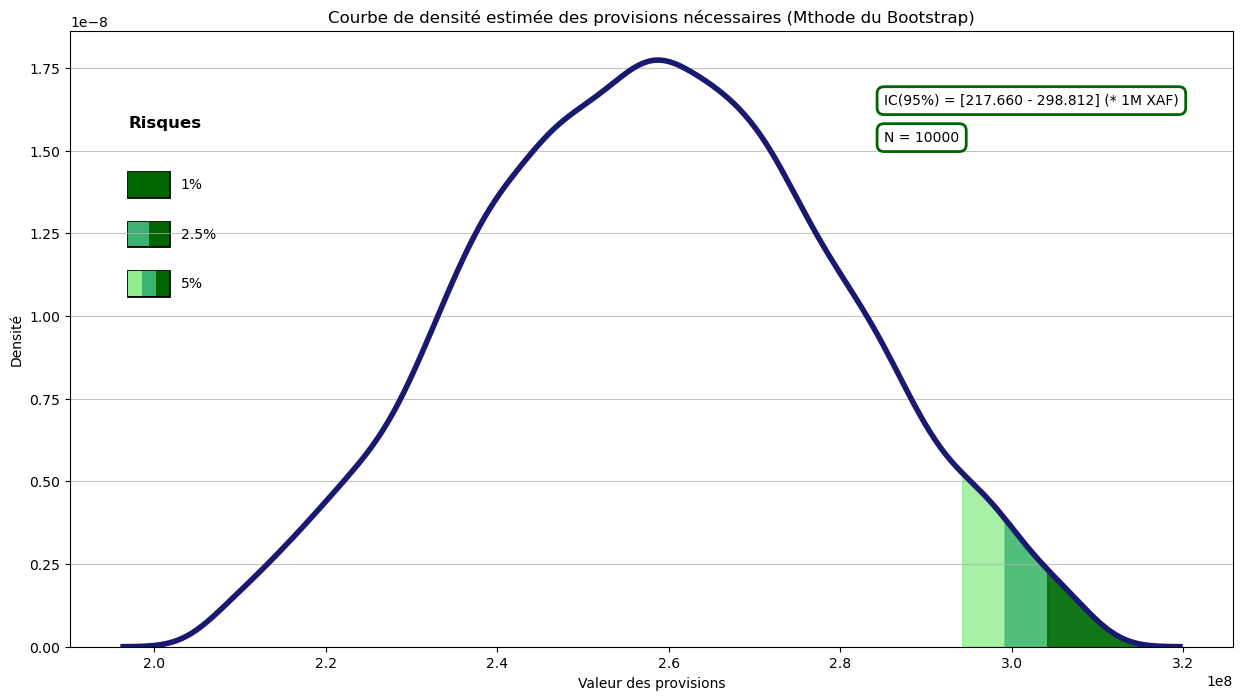

In [104]:
# --- Calcul des percentiles ---
p95_bs = np.percentile(provisions_bs_cleaned, 95)
p97_5_bs = np.percentile(provisions_bs_cleaned, 97.5)
p99_bs = np.percentile(provisions_bs_cleaned, 99)
p2_5_bs = np.percentile(provisions_bs_cleaned, 2.5)

# --- Calcul de l'intervalle de confiance et de N ---
p97_5_ic_bs = np.percentile(provisions_bs_cleaned, 97.5)
nombre_iterations = len(provisions_bs) - 1
IC_value_low = p2_5_bs / 1000000
IC_value_high = p97_5_ic_bs / 1000000

# --- Couleurs pour le graphique ---
couleur_verte_claire = '#90EE90'  # LightGreen
couleur_verte_moyenne = '#3CB371'  # MediumSeaGreen
couleur_verte_foncee = '#006400'  # DarkGreen
couleur_courbe = '#191970'        # Couleur de la courbe de densité

# Création d'une figure et d'un axe pour le tracé principal
fig, ax = plt.subplots(figsize=(15, 8))

# Tracé de la courbe de densité
sns.kdeplot(provisions_bs_cleaned, color=couleur_courbe, linewidth=4, fill=False, ax=ax)

# Récupération des données de la courbe pour le remplissage
x_data, y_data = ax.get_lines()[0].get_xdata(), ax.get_lines()[0].get_ydata()

# Remplissage des zones de risque (avec superposition pour la continuité)
ax.fill_between(x_data, 0, y_data, where=(x_data >= p95_bs), color=couleur_verte_claire, alpha=0.8)
ax.fill_between(x_data, 0, y_data, where=(x_data >= p97_5_bs), color=couleur_verte_moyenne, alpha=0.8)
ax.fill_between(x_data, 0, y_data, where=(x_data >= p99_bs), color=couleur_verte_foncee, alpha=0.8)

# Personnalisation du graphique
ax.set_title('Courbe de densité estimée des provisions nécessaires (Mthode du Bootstrap)')
ax.set_xlabel('Valeur des provisions')
ax.set_ylabel('Densité')
ax.grid(axis='y', alpha=0.75)

# --- Modifications pour la légende des risques ---

# Coordonnées du bloc de légende (ajustez si besoin)
x_legend_pos = 0.05
y_legend_start_pos = 0.85
y_spacing = 0.08

# Titre pour la légende des risques
ax.text(x_legend_pos, y_legend_start_pos, 'Risques', transform=ax.transAxes, fontsize=12, weight='bold', ha='left', va='center')

# Fonction pour créer une légende (rectangle + texte)
def create_legend_box(ax, x_pos, y_pos, colors, label):
    
    # Dimensions du rectangle de fond
    rect_width = 0.035
    rect_height = 0.04
    
    # Création du rectangle de fond avec la bordure
    background_rect = Rectangle((x_pos, y_pos), rect_width, rect_height, 
                                transform=ax.transAxes, facecolor='white', edgecolor='black', lw=2, clip_on=False)
    ax.add_patch(background_rect)
    
    # Remplissage des couleurs à l'intérieur, parfaitement collées
    color_width = rect_width / len(colors)
    for i, color in enumerate(colors):
        color_rect = Rectangle((x_pos + i * color_width, y_pos), color_width, rect_height, 
                               transform=ax.transAxes, facecolor=color, lw=0, clip_on=False)
        ax.add_patch(color_rect)
        
    # Ajout du texte juste après le rectangle
    text_pos_x = x_pos + rect_width + 0.01 
    ax.text(text_pos_x, y_pos + rect_height / 2, label, transform=ax.transAxes, fontsize=10, va='center', ha='left')

# Appel de la fonction pour chaque risque
create_legend_box(ax, x_legend_pos, y_legend_start_pos - y_spacing * 1.5, [couleur_verte_foncee], '1%')
create_legend_box(ax, x_legend_pos, y_legend_start_pos - y_spacing * 2.5, [couleur_verte_moyenne, couleur_verte_foncee], '2.5%')
create_legend_box(ax, x_legend_pos, y_legend_start_pos - y_spacing * 3.5, [couleur_verte_claire, couleur_verte_moyenne, couleur_verte_foncee], '5%')


# --- Ajout de l'intervalle de confiance et de N ---
ax.text(0.70, 0.88, f"IC(95%) = [{IC_value_low:.3f} - {IC_value_high:.3f}] (* 1M XAF)",
        transform=ax.transAxes, fontsize=10, bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='darkgreen', lw=2))

ax.text(0.70, 0.82, f"N = {nombre_iterations}",
        transform=ax.transAxes, fontsize=10, bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='darkgreen', lw=2))

plt.savefig("provision_bootstrap.png")
plt.show()

In [12]:
Q1 = np.percentile(provisions_bs_cleaned, 25)
median = np.percentile(provisions_bs_cleaned, 50)
moyenne = np.mean(provisions_bs_cleaned)
Q3 = np.percentile(provisions_bs_cleaned, 75)

# Calcul du coefficient d'asymétrie de Yule
asymetrie_yule = ((Q3 - median) - (median - Q1)) / (Q3 - Q1)

print(f"Médiane: {median:.2f}")
print(f"Moyenne: {moyenne:.2f}")
print(f"Coefficient d'asymétrie de Yule: {asymetrie_yule:.4f}")

# Interprétation
if asymetrie_yule > 0:
    print("La distribution est asymétrique positive (queue à droite).")
elif asymetrie_yule < 0:
    print("La distribution est asymétrique négative (queue à gauche).")
else:
    print("La distribution est symétrique.")

Médiane: 258246772.00
Moyenne: 258266987.99
Coefficient d'asymétrie de Yule: -0.0095
La distribution est asymétrique négative (queue à gauche).


In [18]:
df_lending = pd.read_csv('TABLE_LENDING_012020_032020.csv', sep = ';')
df_recovery = pd.read_csv('recovery_summary_012020_032020 - Copie.csv',  sep = ';')

# Calcul du total des montants par intervalle (par exemple, par jour ou par heure)
# Pour lending, les colonnes sont 50, 100, etc.
df_lending['total_lending'] = df_lending.iloc[:, 2:].sum(axis=1)

# Pour recovery, les colonnes sont 5, 34, etc.
df_recovery['total_recovery'] = df_recovery.iloc[:, 2:].sum(axis=1)

# Fusionner les deux dataframes sur la date et l'intervalle
# Le nom de la colonne date est différent, donc on la renomme pour la fusion
#df_recovery.rename(columns={'SDATE': 'ref_date'}, inplace=True)
df_combined = pd.merge(df_lending, df_recovery, on=['ref_date', 'interval'], how='outer').fillna(0)

# Calcul du solde cumulé pour les données originales
df_combined['solde_cumule'] = df_combined['total_lending'].cumsum() - df_combined['total_recovery'].cumsum()


In [ ]:
def generate_simulated_trajectory(df_original, num_samples, method='monte_carlo'):
    """Génère une trajectoire de solde cumulé simulée."""
    if method == 'monte_carlo':
        # Pour Monte Carlo, on peut simuler en utilisant une loi paramétrique.
        # Pour simplifier, on prendra la moyenne et l'écart-type des données originales.
        mean_lending = df_original['total_lending'].mean()
        std_lending = df_original['total_lending'].std()
        
        mean_recovery = df_original['total_recovery'].mean()
        std_recovery = df_original['total_recovery'].std()

        simulated_lending = np.random.normal(mean_lending, std_lending, num_samples)
        simulated_recovery = np.random.normal(mean_recovery, std_recovery, num_samples)
        
    elif method == 'bootstrap':
        # Pour Bootstrap, on tire aléatoirement avec remise
        simulated_lending = np.random.choice(df_original['total_lending'], size=num_samples, replace=True)
        simulated_recovery = np.random.choice(df_original['total_recovery'], size=num_samples, replace=True)

    simulated_solde = np.cumsum(simulated_lending - simulated_recovery)
    return pd.Series(simulated_solde)

# Générer deux trajectoires simulées
traj_mc = generate_simulated_trajectory(df_combined, len(df_combined), 'monte_carlo')
traj_bootstrap = generate_simulated_trajectory(df_combined, len(df_combined), 'bootstrap')

In [54]:
def calculer_somme(df):
    sommes = []
    colonnes_a_exclure = ['ref_date', 'interval', 'INTERVAL', 'SDATE', 'SUM_CENTS_PRINCIPAL', 'total_lending', 'total_recovery']
    colonnes_numeriques = [col for col in df.columns if col not in colonnes_a_exclure and pd.to_numeric(col, errors='coerce') is not None]

    df_a_calculer = df[colonnes_numeriques]
    for _, ligne in df_a_calculer.iterrows():
        somme_ligne_actuelle = 0
        for nom_colonne, valeur_cellule in ligne.items():
            valeur_entete = float(nom_colonne)
            valeur_numerique_cellule = float(valeur_cellule)
            somme_ligne_actuelle += valeur_entete * valeur_numerique_cellule
        sommes.append(somme_ligne_actuelle)
    return sommes


def plot_simulation_trajectories(
    lending_file: str,
    recovery_file: str,
    method: str,
    num_iterations: int
):
    
    df_lending = pd.read_csv(lending_file, sep=';')
    df_recovery = pd.read_csv(recovery_file, sep=';')

    df_lending['total_lending'] = calculer_somme(df_lending)
    df_recovery['total_recovery'] = calculer_somme(df_recovery)

    df_combined = pd.merge(df_lending, df_recovery, on=['ref_date', 'INTERVAL'], how='outer').fillna(0)
    df_combined['solde_cumule_original'] = df_combined['total_lending'].cumsum() - df_combined['total_recovery'].cumsum()

    if method.lower() == 'monte_carlo':
        simulation_func = montecarlo
        label = 'Trajectoire Monte Carlo'
        color = 'lightblue'
    elif method.lower() == 'bootstrap':
        simulation_func = bootstrap
        label = 'Trajectoire Bootstrap'
        color = 'lightblue'
    else:
        raise ValueError("La méthode doit être 'monte_carlo' ou 'bootstrap'.")

    plt.figure(figsize=(15, 8))
    plt.plot(df_combined.index, df_combined['solde_cumule_original'], label='Trajectoire Originale', color='blue', linewidth=2)

    for _ in range(num_iterations):
        df_lending_sim = simulation_func(df_lending.copy())
        df_recovery_sim = simulation_func(df_recovery.copy())

        df_lending_sim.index = df_lending.index
        df_recovery_sim.index = df_recovery.index
        
        total_lending_sim = calculer_somme(df_lending_sim)
        total_recovery_sim = calculer_somme(df_recovery_sim)

        simulated_solde = pd.Series(total_lending_sim).cumsum() - pd.Series(total_recovery_sim).cumsum()
        
        plt.plot(simulated_solde.index, simulated_solde, color=color, linewidth=0.5, alpha=0.3)

    plt.plot([], [], color=color, linewidth=2, label=f'Faisceau {label}')
    plt.title(f'Faisceau de Trajectoires des Soldes ({method.capitalize()}) - {num_iterations} itérations')
    plt.xlabel('Période (Ligne de donnée)')
    plt.ylabel('Solde Cumulé')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

In [58]:
#plot_simulation_trajectories('TABLE_LENDING_012020_032020.csv', 'recovery_summary_012020_032020 - Copie.csv', 'monte_carlo', 200)
plot_simulation_trajectories('TABLE_LENDING_012020_032020.csv', 'recovery_summary_012020_032020 - Copie.csv', 'bootstrap', 50)

In [26]:
def montecarlo(df: pd.DataFrame) -> pd.DataFrame:
    n_row = df.shape[0]
    n_col = df.shape[1]
    data_index = df.iloc[:, :2]
    data_value = np.zeros((n_row, n_col - 2))
    intervals = df['INTERVAL'].unique()
    intervals.sort()

    for i in intervals:
        temp = df[df['INTERVAL'] == i]
        temp = temp.iloc[:, 2:]
        lines = [len(intervals) * n + i for n in range(temp.shape[0])]
        for j in range(temp.shape[1]):
            items = temp.iloc[:, j]
            lambda_hat = np.mean(items)
            values = np.random.poisson(lam=lambda_hat, size=temp.shape[0])
            data_value[lines, j] = values
            
    data_value = pd.DataFrame(data_value, columns=df.columns[2:])
    data_final = pd.concat([data_index, data_value], axis=1)    
    return data_final

def bootstrap(df: pd.DataFrame) -> pd.DataFrame:
    n_row = df.shape[0]
    n_col = df.shape[1]
    data_index = df.iloc[:, :2]
    data_value = np.zeros((n_row, n_col - 2))
    intervals = df['INTERVAL'].unique()
    intervals.sort()

    for i in intervals:
        temp = df[df['INTERVAL'] == i]
        temp = temp.iloc[:, 2:]
        lines = [len(intervals) * n + i for n in range(temp.shape[0])]
        for j in range(temp.shape[1]):
            items = temp.iloc[:, j]
            values = np.random.choice(items, size=temp.shape[0], replace=True)
            data_value[lines, j] = values
            
    data_value = pd.DataFrame(data_value, columns=df.columns[2:])
    data_final = pd.concat([data_index, data_value], axis=1)    
    return data_final

def calculer_somme(df):
    sommes = []
    # Liste mise à jour avec les colonnes qui peuvent poser problème
    colonnes_a_exclure = ['ref_date', 'interval', 'INTERVAL', 'SDATE', 'SUM_CENTS_PRINCIPAL', 'total_lending', 'total_recovery']
    colonnes_numeriques = [col for col in df.columns if col not in colonnes_a_exclure and pd.to_numeric(col, errors='coerce') is not None]

    df_a_calculer = df[colonnes_numeriques]
    for _, ligne in df_a_calculer.iterrows():
        somme_ligne_actuelle = 0
        for nom_colonne, valeur_cellule in ligne.items():
            valeur_entete = float(nom_colonne)
            valeur_numerique_cellule = float(valeur_cellule)
            somme_ligne_actuelle += valeur_entete * valeur_numerique_cellule
        sommes.append(somme_ligne_actuelle)
    return sommes


def plot_simulation_trajectories(
    lending_file: str,
    recovery_file: str,
    method: str,
    num_iterations: int
):
    """
    Simule et trace un faisceau de trajectoires des soldes de transactions.
    """
    df_lending = pd.read_csv(lending_file, sep=';')
    df_recovery = pd.read_csv(recovery_file, sep=';')

    df_lending['total_lending'] = calculer_somme(df_lending)
    df_recovery['total_recovery'] = calculer_somme(df_recovery)

    df_combined = pd.merge(df_lending, df_recovery, on=['ref_date', 'INTERVAL'], how='outer').fillna(0)
    df_combined['solde_cumule_original'] = df_combined['total_lending'].cumsum() - df_combined['total_recovery'].cumsum()

    if method.lower() == 'monte_carlo':
        simulation_func = montecarlo
        label = 'Trajectoire Monte Carlo'
        color = 'red'
    elif method.lower() == 'bootstrap':
        simulation_func = bootstrap
        label = 'Trajectoire Bootstrap'
        color = 'green'
    else:
        raise ValueError("La méthode doit être 'monte_carlo' ou 'bootstrap'.")

    plt.figure(figsize=(15, 8))
    plt.plot(df_combined.index, df_combined['solde_cumule_original'], label='Trajectoire Originale', color='blue', linewidth=2)

    for _ in range(num_iterations):
        df_lending_sim = simulation_func(df_lending.copy())
        df_recovery_sim = simulation_func(df_recovery.copy())

        df_lending_sim.index = df_lending.index
        df_recovery_sim.index = df_recovery.index
        
        total_lending_sim = calculer_somme(df_lending_sim)
        total_recovery_sim = calculer_somme(df_recovery_sim)

        simulated_solde = pd.Series(total_lending_sim).cumsum() - pd.Series(total_recovery_sim).cumsum()
        
        plt.plot(simulated_solde.index, simulated_solde, color=color, linewidth=0.5, alpha=0.3)

    plt.plot([], [], color=color, linewidth=2, label=f'Faisceau {label}')
    plt.title(f'Faisceau de Trajectoires des Soldes ({method.capitalize()}) - {num_iterations} itérations')
    plt.xlabel('Période (Ligne de donnée)')
    plt.ylabel('Solde Cumulé')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

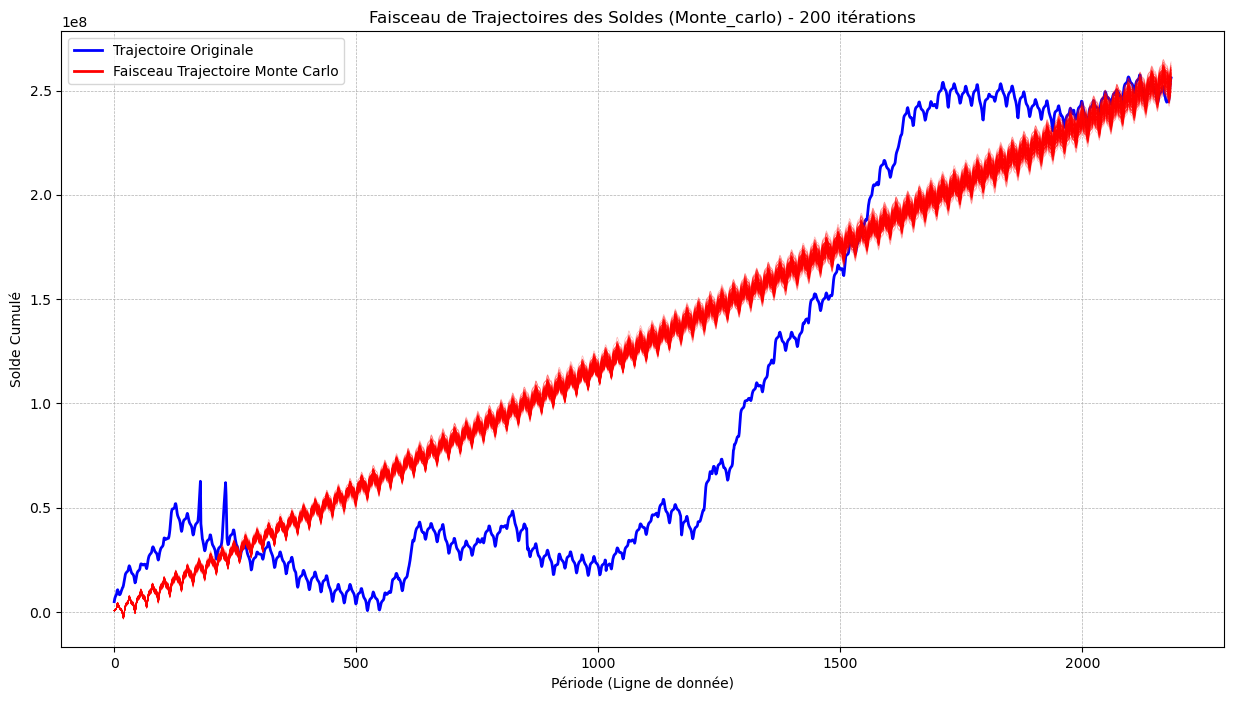

In [27]:
plot_simulation_trajectories('TABLE_LENDING_012020_032020.csv', 'recovery_summary_012020_032020 - Copie.csv', 'monte_carlo', 200)
#plot_simulation_trajectories('TABLE_LENDING_012020_032020.csv', 'recovery_summary_012020_032020 - Copie.csv', 'bootstrap', 200)

In [22]:
def montecarlo(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = df.copy()
    n_rows = len(df_copy)
    
    # Exclure les colonnes non-numériques pour la simulation
    colonnes_numeriques = [col for col in df_copy.columns if isinstance(df_copy[col].iloc[0], (int, float))]
    
    data_value = np.zeros((n_rows, len(colonnes_numeriques)))
    
    # Simulation des données ligne par ligne pour préserver la structure
    for j, col_name in enumerate(colonnes_numeriques):
        lambda_hat = np.mean(df_copy[col_name])
        values = np.random.poisson(lam=lambda_hat, size=n_rows)
        data_value[:, j] = values

    df_simulated = df_copy.copy()
    df_simulated[colonnes_numeriques] = data_value
    
    return df_simulated


def bootstrap(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = df.copy()
    
    # Exclure les colonnes non-numériques pour la simulation
    colonnes_numeriques = [col for col in df_copy.columns if isinstance(df_copy[col].iloc[0], (int, float))]
    
    # Simulation des données ligne par ligne pour préserver la structure
    for j, col_name in enumerate(colonnes_numeriques):
        items = df_copy[col_name]
        values = np.random.choice(items, size=len(items), replace=True)
        df_copy[col_name] = values

    return df_copy


def calculer_somme(df):
    sommes = []
    colonnes_a_exclure = ['ref_date', 'interval', 'INTERVAL', 'SDATE', 'SUM_CENTS_PRINCIPAL', 'total_lending', 'total_recovery', 'solde_cumule_original']
    colonnes_numeriques = [col for col in df.columns if col not in colonnes_a_exclure and pd.to_numeric(col, errors='coerce') is not None]

    df_a_calculer = df[colonnes_numeriques]
    for _, ligne in df_a_calculer.iterrows():
        somme_ligne_actuelle = 0
        for nom_colonne, valeur_cellule in ligne.items():
            valeur_entete = float(nom_colonne)
            valeur_numerique_cellule = float(valeur_cellule)
            somme_ligne_actuelle += valeur_entete * valeur_numerique_cellule
        sommes.append(somme_ligne_actuelle)
    return sommes


def plot_simulation_trajecto(
    lending_file: str,
    recovery_file: str,
    method: str,
    num_iterations: int
):
    
    df_lending = pd.read_csv(lending_file, sep=';')
    df_recovery = pd.read_csv(recovery_file, sep=';')

    df_lending['total_lending'] = calculer_somme(df_lending)
    df_recovery['total_recovery'] = calculer_somme(df_recovery)

    df_combined = pd.merge(df_lending, df_recovery, on=['ref_date', 'INTERVAL'], how='outer').fillna(0)
    df_combined['solde_cumule_original'] = df_combined['total_lending'].cumsum() - df_combined['total_recovery'].cumsum()

    if method.lower() == 'monte_carlo':
        simulation_func = montecarlo
        label = 'Trajectoire Monte Carlo'
        color = 'red'
    elif method.lower() == 'bootstrap':
        simulation_func = bootstrap
        label = 'Trajectoire Bootstrap'
        color = 'green'
    else:
        raise ValueError("La méthode doit être 'monte_carlo' ou 'bootstrap'.")

    plt.figure(figsize=(15, 8))
    plt.plot(df_combined.index, df_combined['solde_cumule_original'], label='Trajectoire Originale', color='blue', linewidth=2)

    for _ in range(num_iterations):
        df_lending_sim = simulation_func(df_lending.copy())
        df_recovery_sim = simulation_func(df_recovery.copy())
        
        total_lending_sim = calculer_somme(df_lending_sim)
        total_recovery_sim = calculer_somme(df_recovery_sim)

        simulated_solde = pd.Series(total_lending_sim).cumsum() - pd.Series(total_recovery_sim).cumsum()
        
        plt.plot(simulated_solde.index, simulated_solde, color=color, linewidth=0.5, alpha=0.3)

    plt.plot([], [], color=color, linewidth=2, label=f'Faisceau {label}')
    plt.title(f'Faisceau de Trajectoires des Soldes ({method.capitalize()}) - {num_iterations} itérations')
    plt.xlabel('Période (Ligne de donnée)')
    plt.ylabel('Solde Cumulé')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()


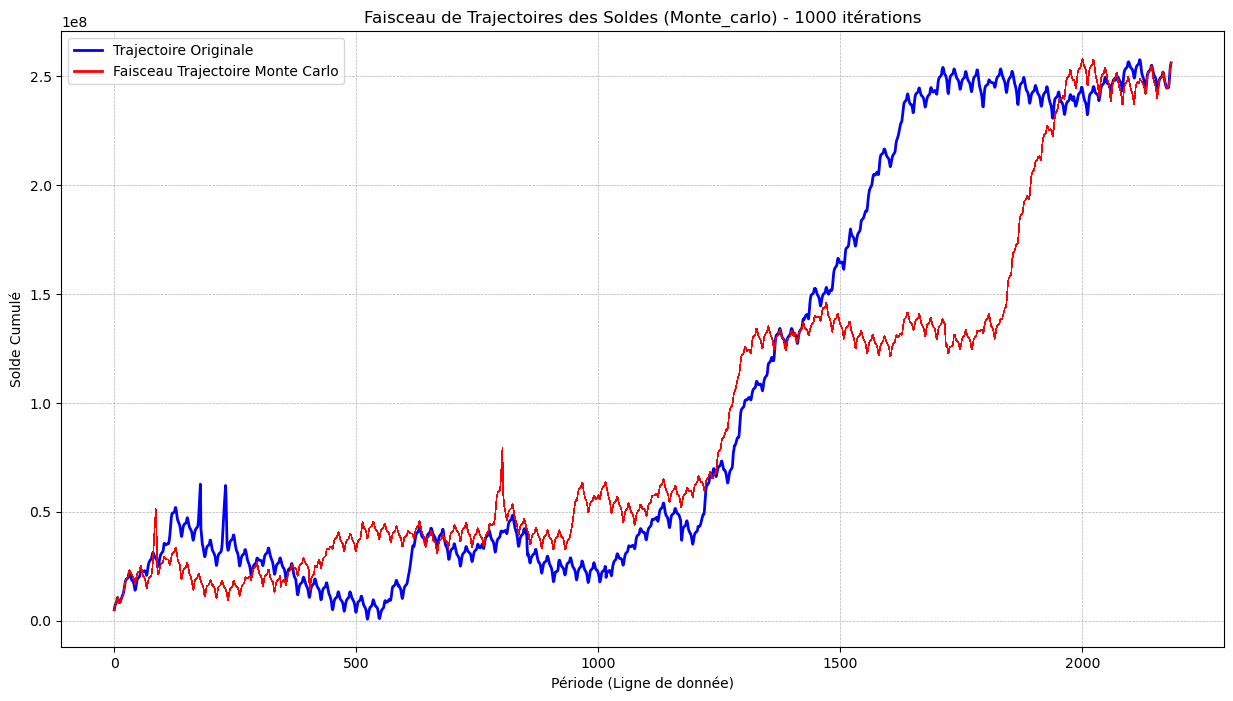

In [23]:
#plot_simulation_trajecto('TABLE_LENDING_012020_032020.csv', 'recovery_summary_012020_032020 - Copie.csv', 'bootstrap', 10)
plot_simulation_traject('TABLE_LENDING_012020_032020.csv', 'recovery_summary_012020_032020 - Copie.csv', 'monte_carlo', 1000)

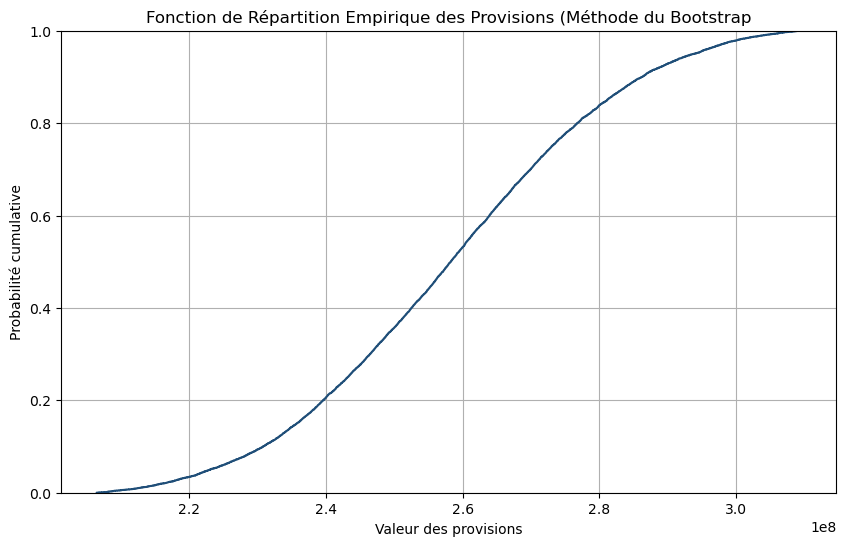

In [105]:
# --- Création de la figure de la fonction de répartition ---
plt.figure(figsize=(10, 6))

# Tracé de la CDF
# 'ecdfplot' de Seaborn calcule et trace la fonction de répartition empirique.
sns.ecdfplot(data=provisions_bs_cleaned, color='#1F4E78')

# Personnalisation du graphique
plt.title('Fonction de Répartition Empirique des Provisions (Méthode du Bootstrap')
plt.xlabel('Valeur des provisions')
plt.ylabel('Probabilité cumulative')
plt.grid(True)
plt.savefig("fonction_repartition_bs.png")
plt.show()

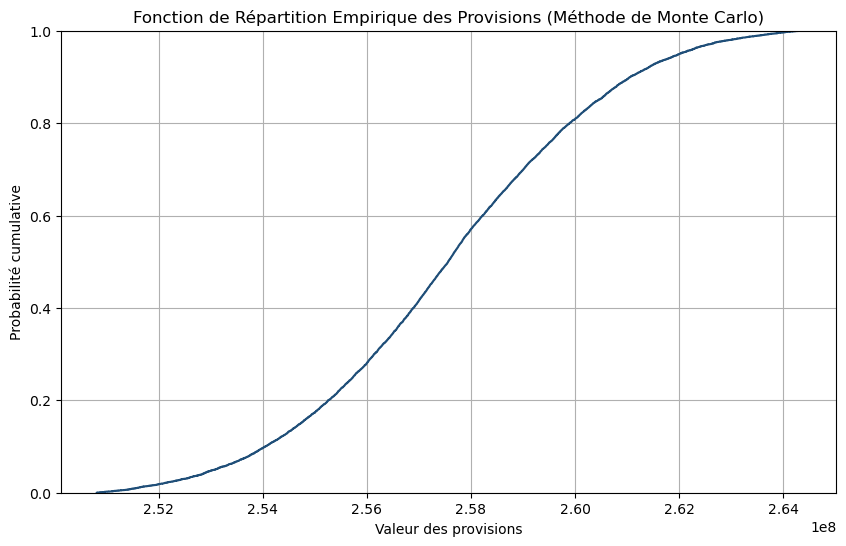

In [106]:
# --- Création de la figure de la fonction de répartition ---
plt.figure(figsize=(10, 6))

# Tracé de la CDF
# 'ecdfplot' de Seaborn calcule et trace la fonction de répartition empirique.
sns.ecdfplot(data=provisions_mc_cleaned, color='#1F4E78')

# Personnalisation du graphique
plt.title('Fonction de Répartition Empirique des Provisions (Méthode de Monte Carlo)')
plt.xlabel('Valeur des provisions')
plt.ylabel('Probabilité cumulative')
plt.grid(True)
plt.savefig("fonction_repartition_mc.png")
plt.show()

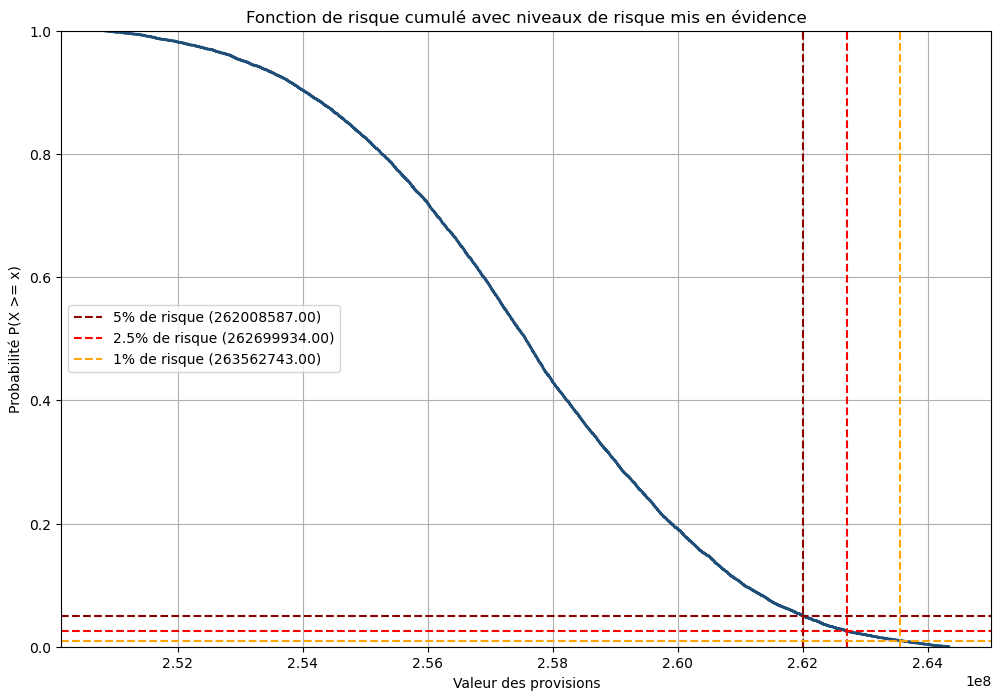

In [107]:
# Création de la figure de la fonction de risque cumulé
fig, ax = plt.subplots(figsize=(12, 8))

# Tracé de la fonction de survie
sns.ecdfplot(data=provisions_mc_cleaned, complementary=True, color='#1F4E78', linewidth=2, ax=ax)

# Extraction des données de la courbe ECDF
line = ax.get_lines()[0]
x_ecdf, y_ecdf = line.get_xdata(), line.get_ydata()

# Fonction pour trouver le point d'intersection sur la courbe
def find_intersection(y_target, x_data, y_data):
    # Trouver l'indice du premier point où la probabilité est inférieure ou égale à la cible
    index = np.where(y_data <= y_target)[0][0]
    return x_data[index]

# Points d'intersection pour les niveaux de risque
x_5_percent = find_intersection(0.05, x_ecdf, y_ecdf)
x_2_5_percent = find_intersection(0.025, x_ecdf, y_ecdf)
x_1_percent = find_intersection(0.01, x_ecdf, y_ecdf)

# Ajout des lignes pour les risques de 5%, 2.5% et 1%
# Lignes pour 5% de risque
ax.axhline(y=0.05, color='darkred', linestyle='--', linewidth=1.5)
ax.axvline(x=x_5_percent, color='darkred', linestyle='--', linewidth=1.5, label=f'5% de risque ({x_5_percent:.2f})')

# Lignes pour 2.5% de risque
ax.axhline(y=0.025, color='red', linestyle='--', linewidth=1.5)
ax.axvline(x=x_2_5_percent, color='red', linestyle='--', linewidth=1.5, label=f'2.5% de risque ({x_2_5_percent:.2f})')

# Lignes pour 1% de risque
ax.axhline(y=0.01, color='orange', linestyle='--', linewidth=1.5)
ax.axvline(x=x_1_percent, color='orange', linestyle='--', linewidth=1.5, label=f'1% de risque ({x_1_percent:.2f})')

# Ajout d'une ligne pour le 50e percentile (la médiane) pour référence
#median_value = np.percentile(provisions_mc, 50)
#ax.axvline(x=median_value, color='green', linestyle=':', linewidth=1.5, label=f'Médiane ({median_value:.2f})')

# Personnalisation du graphique
ax.set_title('Fonction de risque cumulé avec niveaux de risque mis en évidence')
ax.set_xlabel('Valeur des provisions')
ax.set_ylabel('Probabilité P(X >= x)')
ax.legend()
ax.grid(True)
plt.savefig("test.png")
plt.show()

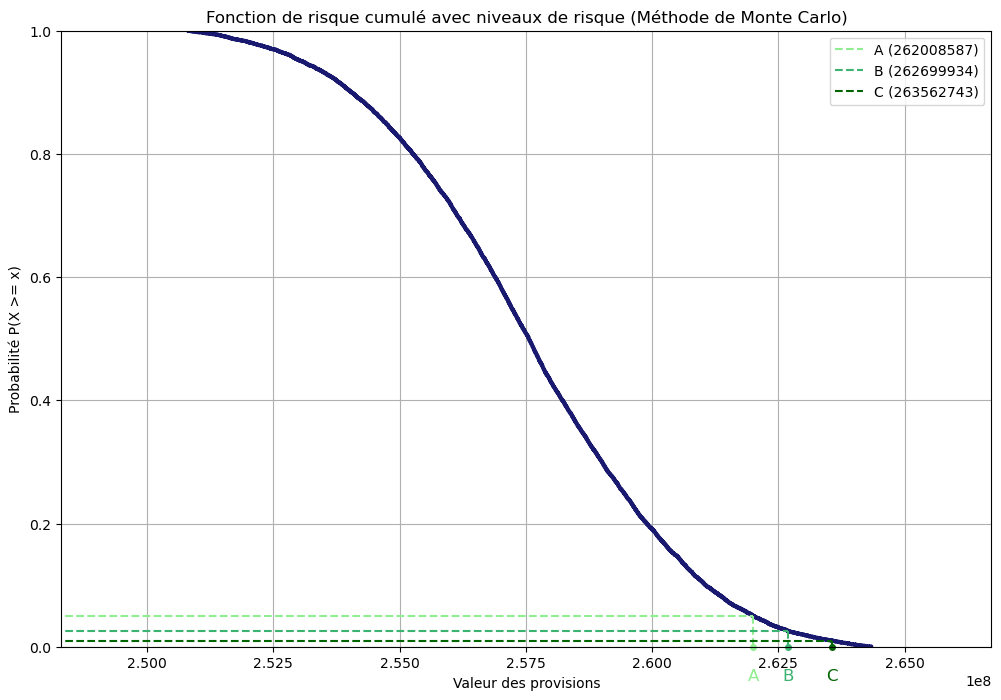

In [127]:
# Création de la figure de la fonction de risque cumulé
fig, ax = plt.subplots(figsize=(12, 8))

# Tracé de la fonction de survie
sns.ecdfplot(data=provisions_mc_cleaned, complementary=True, color='#191970', linewidth=3, ax=ax)

# Extraction des données de la courbe ECDF
line = ax.get_lines()[0]
x_ecdf, y_ecdf = line.get_xdata(), line.get_ydata()

# --- Définir la limite de l'axe des x pour garder la forme de la courbe ---
# Vous pouvez ajuster cette valeur pour qu'elle corresponde à votre besoin
#x_max_limite = np.max(provisions_mc) * 1.009 # Exemple de valeur, ajustez si nécessaire
ax.set_xlim(left=np.min(provisions_mc_cleaned) * 0.99, right=np.max(provisions_mc_cleaned) * 1.009)

# Pour éviter d'avoir de nombreux zéros sur l'axe des x
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))


# Fonction pour trouver le point d'intersection sur la courbe
def find_intersection(y_target, x_data, y_data):
    # Trouver l'indice du premier point où la probabilité est inférieure ou égale à la cible
    index = np.where(y_data <= y_target)[0][0]
    return x_data[index]

# Points d'intersection pour les niveaux de risque
x_5_percent = find_intersection(0.05, x_ecdf, y_ecdf)
x_2_5_percent = find_intersection(0.025, x_ecdf, y_ecdf)
x_1_percent = find_intersection(0.01, x_ecdf, y_ecdf)

# --- Définition des couleurs et des points ---
colors = ['lightgreen', 'MediumSeaGreen', 'darkgreen']
labels = ['A', 'B', 'C']
risk_levels = [0.05, 0.025, 0.01]
x_intersections = [x_5_percent, x_2_5_percent, x_1_percent]

# Boucle pour tracer les lignes et les points
for i, risk in enumerate(risk_levels):
    x = x_intersections[i]
    color = colors[i]
    label = labels[i]
    
    # Ligne horizontale de l'axe Y à la courbe
    ax.plot([0, x], [risk, risk], color=color, linestyle='--', linewidth=1.5)
    
    # Ligne verticale de la courbe à l'axe X
    ax.plot([x, x], [risk, 0], color=color, linestyle='--', linewidth=1.5, label=f'{label} ({x:.0f})')

    
    # Ajout du point A, B ou C sur l'axe des abscisses
    ax.plot(x, 0, marker='o', color=color, markersize=4, clip_on=False)
    ax.text(x, -0.035, label, ha='center', va='top', color=color, fontsize=12)

# Personnalisation du graphique
ax.set_title('Fonction de risque cumulé avec niveaux de risque (Méthode de Monte Carlo)')
ax.set_xlabel('Valeur des provisions')
ax.set_ylabel('Probabilité P(X >= x)')
ax.legend()
ax.grid(True)
plt.savefig("foncton_risque_mc.png")
plt.show()

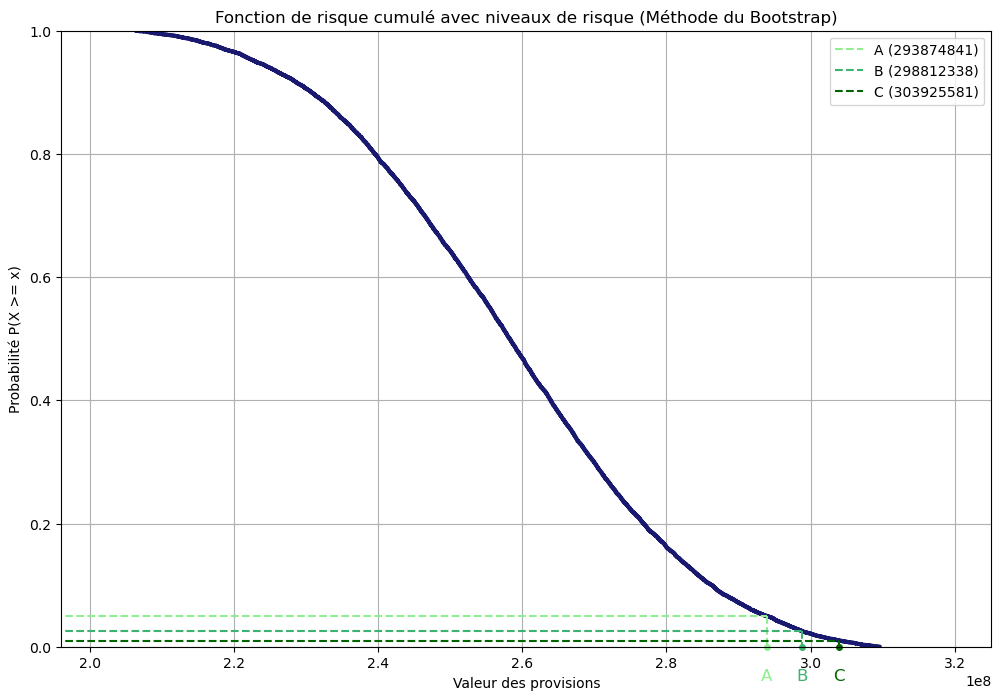

In [126]:
# Création de la figure de la fonction de risque cumulé
fig, ax = plt.subplots(figsize=(12, 8))

# Tracé de la fonction de survie
sns.ecdfplot(data=provisions_bs_cleaned, complementary=True, color='#191970', linewidth=3, ax=ax)

# Extraction des données de la courbe ECDF
line = ax.get_lines()[0]
x_ecdf, y_ecdf = line.get_xdata(), line.get_ydata()

# --- Définir la limite de l'axe des x pour garder la forme de la courbe ---
ax.set_xlim(left=np.min(provisions_bs_cleaned) * 0.95, right=np.max(provisions_bs_cleaned) * 1.05)

# Pour éviter d'avoir de nombreux zéros sur l'axe des x
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))


# Fonction pour trouver le point d'intersection sur la courbe
def find_intersection(y_target, x_data, y_data):
    # Trouver l'indice du premier point où la probabilité est inférieure ou égale à la cible
    index = np.where(y_data <= y_target)[0][0]
    return x_data[index]

# Points d'intersection pour les niveaux de risque
x_5_percent = find_intersection(0.05, x_ecdf, y_ecdf)
x_2_5_percent = find_intersection(0.025, x_ecdf, y_ecdf)
x_1_percent = find_intersection(0.01, x_ecdf, y_ecdf)

# --- Définition des couleurs et des points ---
colors = ['lightgreen', 'MediumSeaGreen', 'darkgreen']
labels = ['A', 'B', 'C']
risk_levels = [0.05, 0.025, 0.01]
x_intersections = [x_5_percent, x_2_5_percent, x_1_percent]

# Boucle pour tracer les lignes et les points
for i, risk in enumerate(risk_levels):
    x = x_intersections[i]
    color = colors[i]
    label = labels[i]
    
    # Ligne horizontale de l'axe Y à la courbe
    ax.plot([0, x], [risk, risk], color=color, linestyle='--', linewidth=1.5)
    
    # Ligne verticale de la courbe à l'axe X
    ax.plot([x, x], [risk, 0], color=color, linestyle='--', linewidth=1.5, label=f'{label} ({x:.0f})')
    
    # Ajout du point A, B ou C sur l'axe des abscisses
    ax.plot(x, 0, marker='o', color=color, markersize=4, clip_on=False)
    ax.text(x, -0.035, label, ha='center', va='top', color=color, fontsize=12)

# Personnalisation du graphique
ax.set_title('Fonction de risque cumulé avec niveaux de risque (Méthode du Bootstrap)')
ax.set_xlabel('Valeur des provisions')
ax.set_ylabel('Probabilité P(X >= x)')
ax.legend()
ax.grid(True)
plt.savefig("foncton_risque_bs.png")
plt.show()

# ANALYSE DESCRIPTIVE

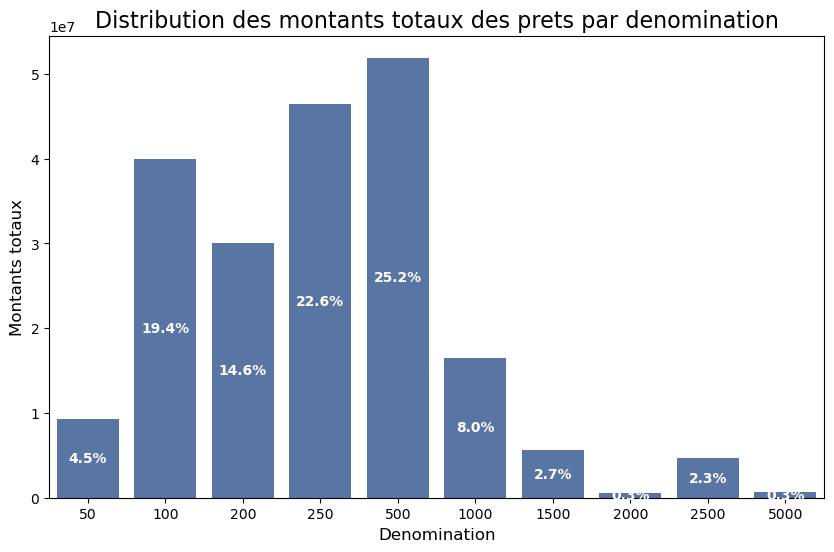

In [48]:
total_amount = volume_par_denomination.sum()
loan_amount_percentages = (volume_par_denomination / total_amount) * 100
bar_color = '#4c72b0'  # Couleur bleue par défaut pour les barres
text_color = 'white'   # Couleur blanche pour les pourcentages

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=volume_par_denomination.index, y=volume_par_denomination.values, color=bar_color)

for bar, percentage in zip(ax.patches, loan_amount_percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2., 
            height / 2,  # Positionner le texte au milieu 
            f'{percentage:.1f}%', 
            ha='center', 
            va='center',
            color=text_color, 
            fontweight='bold')

plt.title('Distribution des montants totaux des prets par denomination', fontsize=16)
plt.xlabel('Denomination', fontsize=12)
plt.ylabel('Montants totaux', fontsize=12)
plt.show()

## I- CHARGEMENT DES DONNEES

In [4]:
features = pd.read_excel("FIRST_01_2020.xlsx")

In [7]:
features_copy = features.copy()

In [4]:
features.head()

loan_id loan_channel  denomination   date_ref  duration_dd day_of_week  \
0  670865664        VOICE            50 2020-01-01     0.001149    MERCREDI   
1  670851878        VOICE            50 2020-01-01     0.017094    MERCREDI   
2  670848463        VOICE            50 2020-01-01     0.017404    MERCREDI   
3  679174522        VOICE           250 2020-01-17     7.370629    VENDREDI   
4  682015908        VOICE           250 2020-01-22     0.439262    MERCREDI   

  period_of_week period_of_month  cents_principal  fees  nb_recovery_trans  
0   THE WORKWEEK     Early_Month             50.0   5.0                1.0  
1   THE WORKWEEK     Early_Month             50.0   5.0                1.0  
2   THE WORKWEEK     Early_Month             50.0   5.0                1.0  
3   THE WORKWEEK      Late_Month            250.0  25.0                1.0  
4   THE WORKWEEK      Late_Month            250.0  25.0                1.0

In [12]:
features[features['loan_channel'] == "SMS"].shape

(36284, 11)

# II-ANALYSE UNIVARIEE

### II - 1- VARIABES QUALITATIVES

#### LOAN_CHANNEL

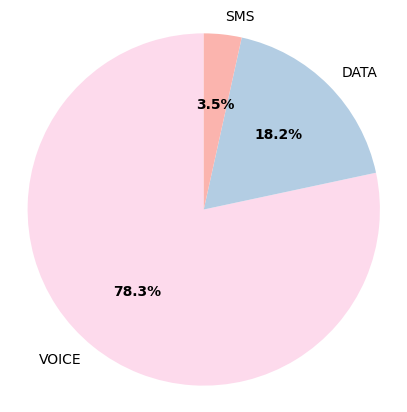

In [5]:
loan_counts = features['loan_channel'].value_counts()

plt.figure(figsize=(5, 5))
patches, texts, autotexts = plt.pie(
    loan_counts,
    labels=loan_counts.index,
    autopct='%1.1f%%',  
    startangle=90,      
    colors=plt.cm.Pastel1(loan_counts / loan_counts.sum())
)
for text in autotexts:
    text.set_color('black')  
    text.set_fontweight('bold') 
    text.set_fontsize(10) 
#plt.title('Répartition des emprunts par canal de prêt', fontsize=16)
plt.axis('equal')

plt.savefig('emprunts_loanchannel.png', dpi=300)
plt.show()

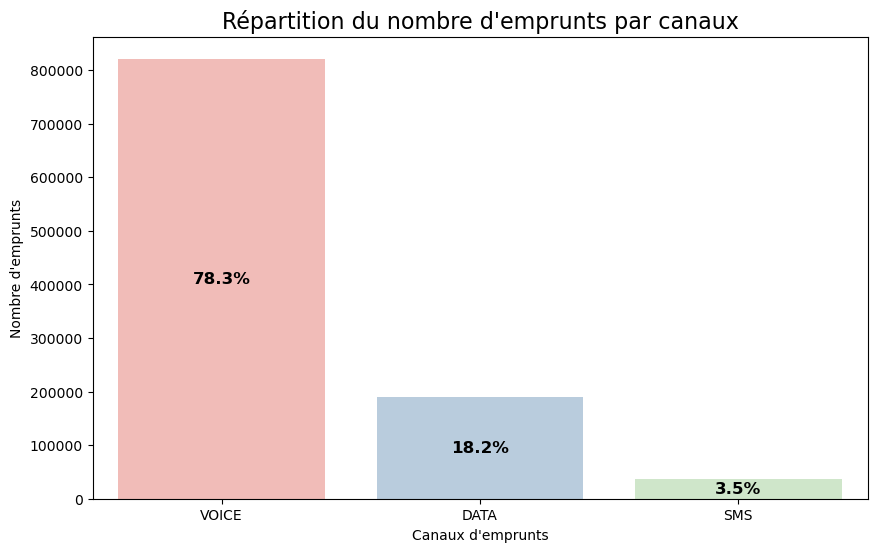

In [116]:
loan_channel_counts = features['loan_channel'].value_counts()
total_count = len(features['loan_channel'])
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=loan_channel_counts.index, y=loan_channel_counts.values, palette='Pastel1')

for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        percentage = (height / total_count) * 100
        ax.text(patch.get_x() + patch.get_width() / 2, height / 2, 
                f'{percentage:.1f}%',
                ha = 'center', va = 'center',
                fontsize = 12, color = 'black', weight = 'bold')
plt.title('Répartition du nombre d\'emprunts par canaux', fontsize=16)
plt.xlabel('Canaux d\'emprunts')
plt.ylabel("Nombre d'emprunts")

plt.show()

In [6]:
total_amount_by_loan_channel = features.groupby('loan_channel')['denomination'].sum().sort_values(ascending=False)
print(total_amount_by_loan_channel)

loan_channel
VOICE    170541450
DATA      28772050
SMS        6358250
Name: denomination, dtype: int64


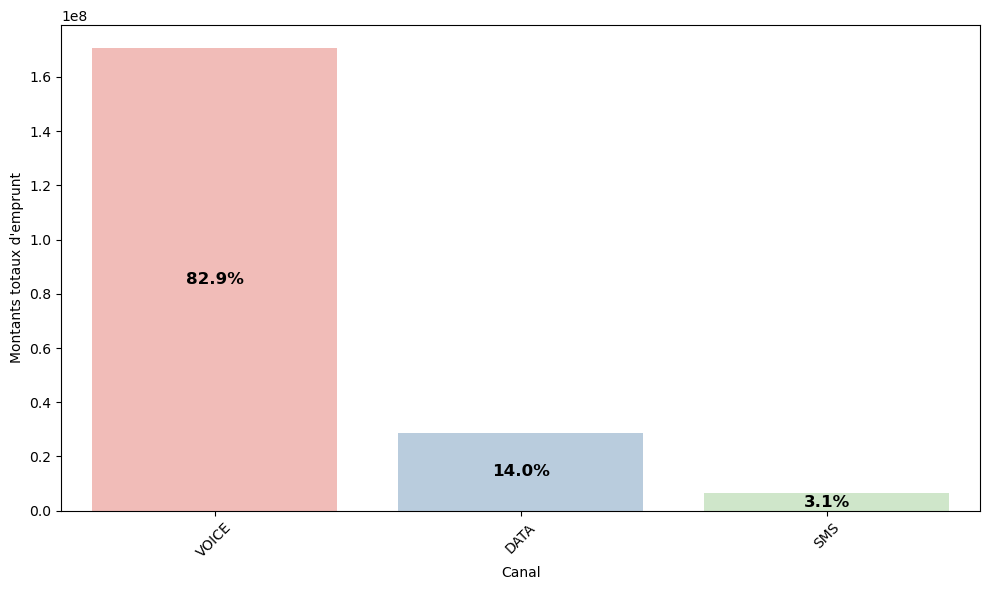

In [8]:
total_amount_by_loan_channel = features.groupby('loan_channel')['denomination'].sum().sort_values(ascending=False)
total_sum = total_amount_by_loan_channel.sum()
percentages = (total_amount_by_loan_channel / total_sum) * 100
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=total_amount_by_loan_channel.index, y=total_amount_by_loan_channel.values, palette='Pastel1', order=total_amount_by_loan_channel.index)
#plt.title('Montant total des emprunts par canal', fontsize=16)
plt.xlabel('Canal')
plt.ylabel('Montants totaux d\'emprunt')
for index, p in enumerate(ax.patches):
    percentage = percentages.iloc[index]
    ax.annotate(
        f'{percentage:.1f}%',
        (p.get_x() + p.get_width() / 2., p.get_height() / 2),
        ha='center',
        va='center',
        fontsize=12,
        color='black',
        weight='bold'
    )

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("montant_par_loan_channel.png", dpi = 300)
plt.show()

#### denomination

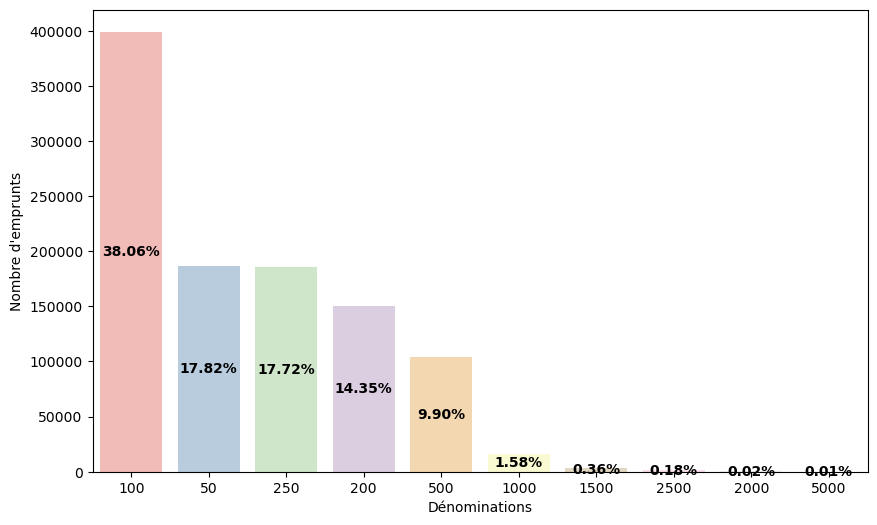

In [10]:
denomination_counts = features['denomination'].value_counts()
total_count = len(features['denomination'])

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=denomination_counts.index, 
    y=denomination_counts.values, 
    palette='Pastel1',
    order=denomination_counts.index
)
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        percentage = (height / total_count) * 100
        ax.text(
            patch.get_x() + patch.get_width() / 2, 
            height / 2, 
            f'{percentage:.2f}%',
            ha = 'center', 
            va = 'center',
            fontsize = 10, 
            color = 'black', 
            weight = 'bold'
        )

#plt.title('Répartition du nombre d\'emprunts par dénomination', fontsize=16)
plt.xlabel('Dénominations')
plt.ylabel("Nombre d\'emprunts")
plt.savefig("emprunts_denomination.png", dpi = 300)
plt.show()

In [12]:
total_amount_by_denomination = features.groupby('denomination')['denomination'].sum().sort_values(ascending=False)
print(total_amount_by_denomination)

denomination
500     51916500
250     46448750
100     39911400
200     30101400
1000    16519000
50       9340700
1500     5605500
2500     4677500
5000      635000
2000      516000
Name: denomination, dtype: int64


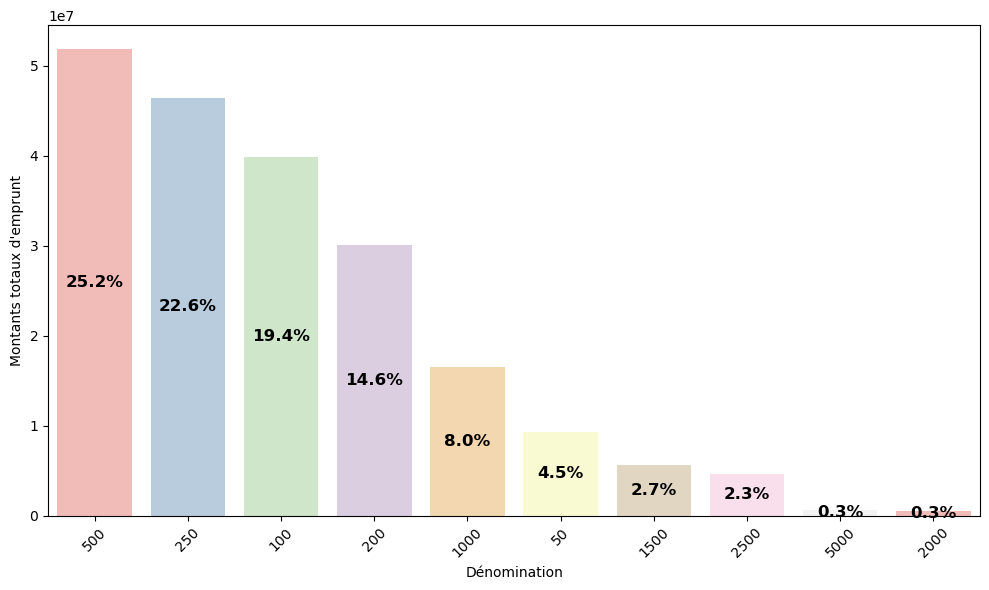

In [9]:
total_amount_by_denomination = features.groupby('denomination')['denomination'].sum().sort_values(ascending=False)
total_sum = total_amount_by_denomination.sum()
percentages = (total_amount_by_denomination / total_sum) * 100
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=total_amount_by_denomination.index, y=total_amount_by_denomination.values, palette='Pastel1', order=total_amount_by_denomination.index)
#plt.title('Montant total des emprunts par dénomination', fontsize=16)
plt.xlabel('Dénomination')
plt.ylabel('Montants totaux d\'emprunt')
for index, p in enumerate(ax.patches):
    percentage = percentages.iloc[index]
    ax.annotate(
        f'{percentage:.1f}%',
        (p.get_x() + p.get_width() / 2., p.get_height() / 2),
        ha='center',
        va='center',
        fontsize=12,
        color='black',
        weight='bold'
    )

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('emprunts_par_denomination.png', dpi = 300)
plt.show()

#### day_of_week

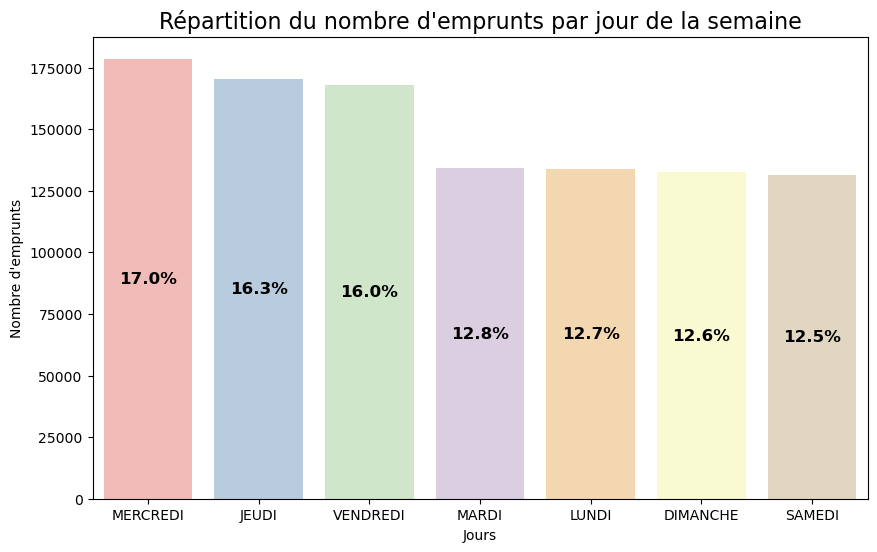

In [41]:
dow_counts = features['day_of_week'].value_counts()
total_count = len(features['day_of_week'])
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=dow_counts.index, y=dow_counts.values, palette='Pastel1')

for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        percentage = (height / total_count) * 100
        ax.text(patch.get_x() + patch.get_width() / 2, height / 2, 
                f'{percentage:.1f}%',
                ha = 'center', va = 'center',
                fontsize = 12, color = 'black', weight = 'bold')
plt.title('Répartition du nombre d\'emprunts par jour de la semaine', fontsize=16)
plt.xlabel('Jours')
plt.ylabel("Nombre d\'emprunts")
plt.savefig('day_of_week.png')
plt.show()

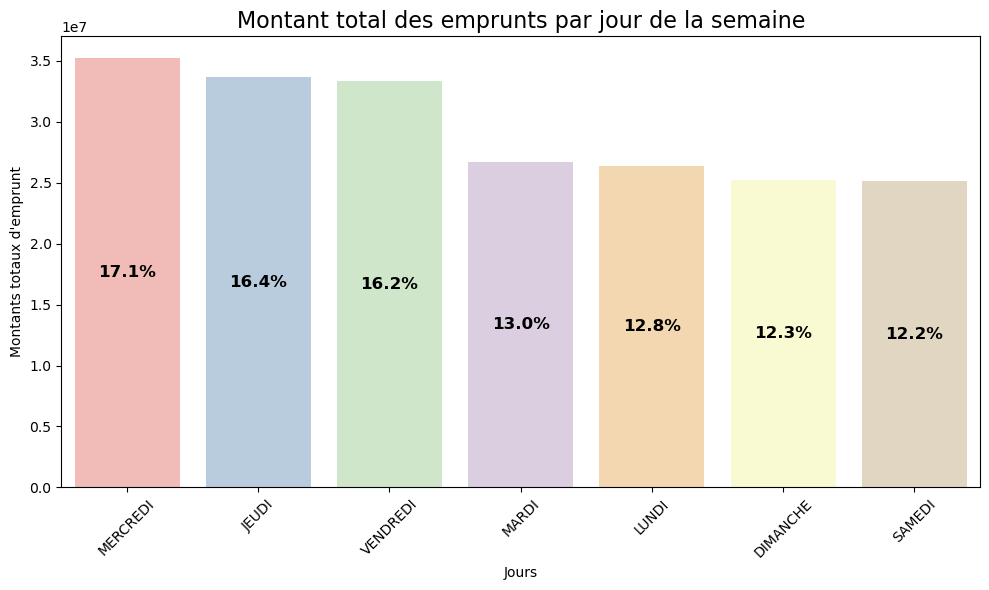

In [120]:
total_amount_by_dow = features.groupby('day_of_week')['denomination'].sum().sort_values(ascending=False)
total_sum = total_amount_by_dow.sum()
percentages = (total_amount_by_dow / total_sum) * 100
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=total_amount_by_dow.index, y=total_amount_by_dow.values, palette='Pastel1')
plt.title('Montant total des emprunts par jour de la semaine', fontsize=16)
plt.xlabel('Jours')
plt.ylabel('Montants totaux d\'emprunt')
for index, p in enumerate(ax.patches):
    percentage = percentages.iloc[index]
    ax.annotate(
        f'{percentage:.1f}%',
        (p.get_x() + p.get_width() / 2., p.get_height() / 2),
        ha='center',
        va='center',
        fontsize=12,
        color='black',
        weight='bold'
    )

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

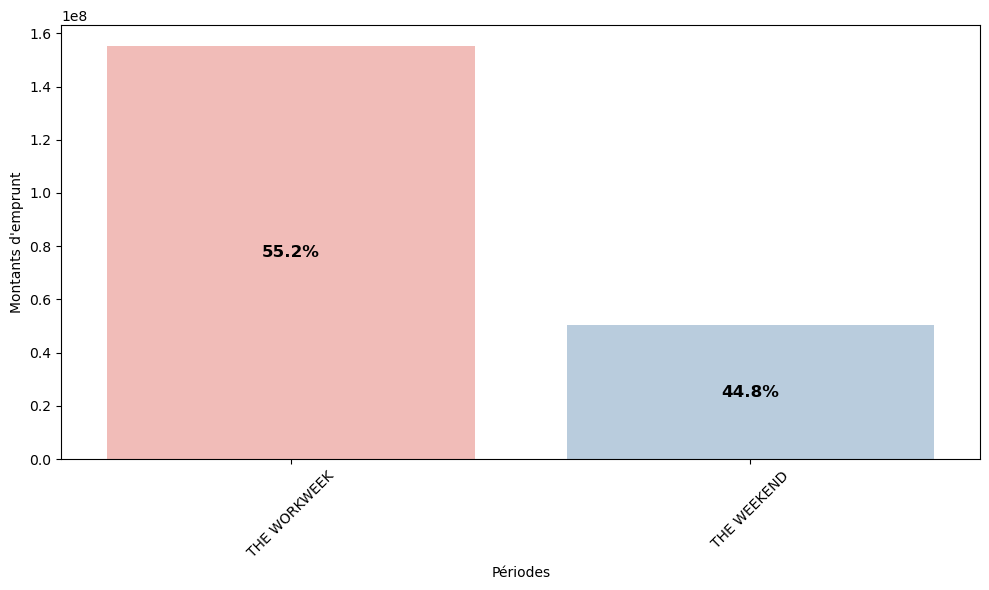

In [47]:
total_amount_by_pow = features.groupby('period_of_week')['denomination'].sum().sort_values(ascending=False)
diviseurs = {'THE WORKWEEK': 5, 'THE WEEKEND': 2}
diviseurs_series = pd.Series(diviseurs)
mean_by_period = total_amount_by_pow / diviseurs_series
total_sum = mean_by_period.sum()
percentages = (mean_by_period / total_sum) * 100
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=total_amount_by_pow.index, y=total_amount_by_pow.values, palette='Pastel1')
#plt.title('Montant total des emprunts par jour de la semaine', fontsize=16)
plt.xlabel('Périodes')
plt.ylabel('Montants d\'emprunt')
for index, p in enumerate(ax.patches):
    percentage = percentages.iloc[index]
    ax.annotate(
        f'{percentage:.1f}%',
        (p.get_x() + p.get_width() / 2., p.get_height() / 2),
        ha='center',
        va='center',
        fontsize=12,
        color='black',
        weight='bold'
    )

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('montant_period_of_week.png', dpi = 300)
plt.show()

In [25]:
total_amount_by_po = features.groupby('period_of_week')['denomination'].sum()
diviseurs = {'THE WORKWEEK': 5, 'THE WEEKEND': 2}
diviseurs_series = pd.Series(diviseurs)
mean_by_period = total_amount_by_po / diviseurs_series
print("Moyenne des dénominations par période de la semaine :")
print(mean_by_period)

Moyenne des dénominations par période de la semaine :
THE WEEKEND     25189500.0
THE WORKWEEK    31058550.0
dtype: float64


#### period_of_week

#### period_of_month

In [39]:
features['period_of_month'].value_counts()

period_of_month
Early_Month    414064
Mid_Month      338843
Late_Month     295668
Name: count, dtype: int64

In [5]:
observed_counts = features['period_of_month'].value_counts()
print("Comptages observés :")
print(observed_counts)

Comptages observés :
period_of_month
Early_Month    414064
Mid_Month      338843
Late_Month     295668
Name: count, dtype: int64


In [8]:
total_transactions = len(features)
expected_counts = total_transactions / len(observed_counts)
expected_counts_list = [expected_counts] * len(observed_counts)
print("\nComptages attendus (sous H0) :")
print(expected_counts_list)
chi2_statistic, p_value = chisquare(f_obs=observed_counts, f_exp=expected_counts_list)

print(f"\nStatistique du Chi-2 : {chi2_statistic}")
print(f"p-value : {p_value}")
alpha = 0.05
print("\n--- Interprétation ---")
if p_value < alpha:
    print("La p-value est inférieure à 0.05. On rejette l'hypothèse nulle.")
    print("Il y a une différence statistiquement significative dans la répartition des transactions par période du mois.")
else:
    print("La p-value est supérieure à 0.05. On ne peut pas rejeter l'hypothèse nulle.")
    print("Il n'y a pas de preuve d'une différence significative dans la répartition des transactions par période du mois.")


Comptages attendus (sous H0) :
[349525.0, 349525.0, 349525.0]

Statistique du Chi-2 : 20542.0616379372
p-value : 0.0

--- Interprétation ---
La p-value est inférieure à 0.05. On rejette l'hypothèse nulle.
Il y a une différence statistiquement significative dans la répartition des transactions par période du mois.


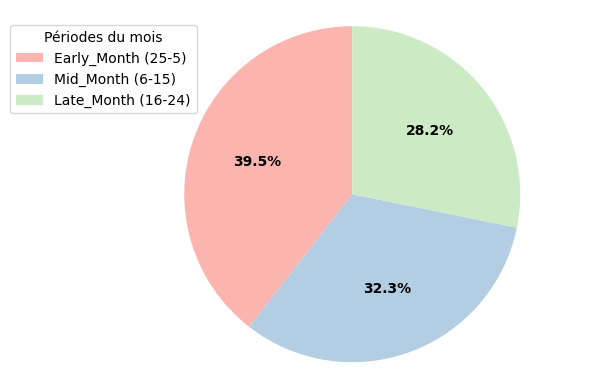

In [34]:
loan_counts = features['period_of_month'].value_counts()
legend_labels = []
for period in loan_counts.index:
    if period == 'Early_Month':
        legend_labels.append(f"Early_Month (25-5)")
    elif period == 'Mid_Month':
        legend_labels.append(f"Mid_Month (6-15)")
    elif period == 'Late_Month':
        legend_labels.append(f"Late_Month (16-24)")
    else:
        legend_labels.append(period)
patches, texts, autotexts = plt.pie(
    loan_counts,
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Pastel1(range(len(loan_counts)))
)
for text in autotexts:
    text.set_color('black')  
    text.set_fontweight('bold') 
    text.set_fontsize(10) 
plt.legend(
    patches, 
    legend_labels,
    title="Périodes du mois",
    loc="best",
    bbox_to_anchor=(0.2, 0.7)
)
#plt.title('Répartition des emprunts par période du mois', fontsize=14)
plt.axis('equal')
plt.savefig('figure_period_of_month.png', dpi=300)
plt.show()

In [40]:
print(total_amount_by_pom)

period_of_month
Early_Month    80998250
Mid_Month      66752900
Late_Month     57920600
Name: denomination, dtype: int32


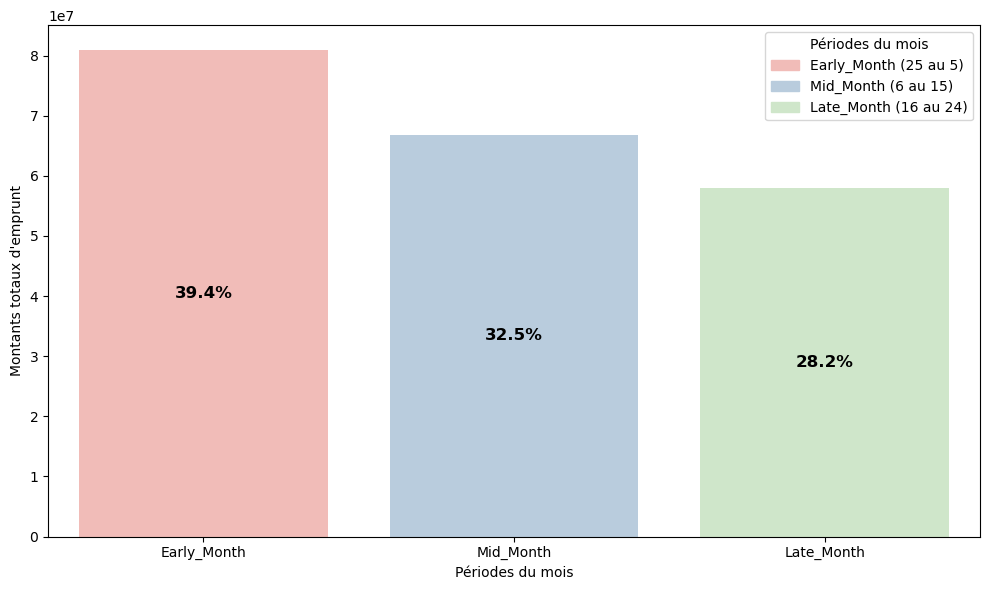

In [33]:
features['denomination'] = features['denomination'].astype(int)
total_amount_by_pom = features.groupby('period_of_month')['denomination'].sum().sort_values(ascending=False)
total_sum = total_amount_by_pom.sum()
percentages = (total_amount_by_pom / total_sum) * 100
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=total_amount_by_pom.index,
    y=total_amount_by_pom.values,
    palette='Pastel1',
    order=total_amount_by_pom.index
)
for index, p in enumerate(ax.patches):
    percentage = percentages.iloc[index]
    ax.annotate(
        f'{percentage:.1f}%',
        (p.get_x() + p.get_width() / 2., p.get_height() / 2),
        ha='center',
        va='center',
        fontsize=12,
        color='black',
        weight='bold'
    )
legend_labels = [
    f'Early_Month (25 au 5)',
    f'Mid_Month (6 au 15)',
    f'Late_Month (16 au 24)'
]
legend_colors = [p.get_facecolor() for p in ax.patches]
legend_patches = [mpatches.Patch(color=legend_colors[i], label=legend_labels[i]) for i in range(len(legend_labels))]
ax.legend(handles=legend_patches, title='Périodes du mois', loc='upper right')
#plt.title('Montant total des emprunts par période du mois', fontsize=16)
plt.xlabel('Périodes du mois')
plt.ylabel('Montants totaux d\'emprunt')
plt.xticks(rotation=0)  
plt.tight_layout()
plt.savefig('montant_period_of_month.png', dpi = 300)
plt.show()

### II - 2- VARIABLE QUANTITATIVE

#### duration_dd

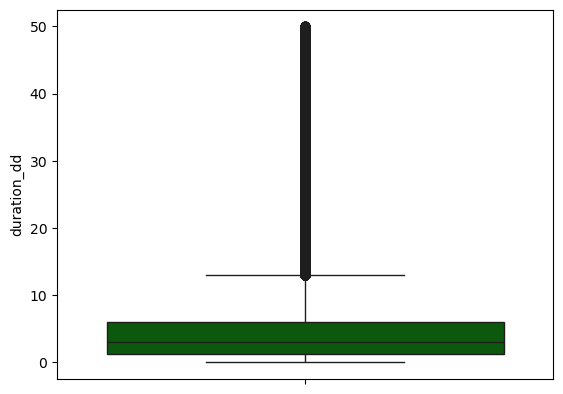

In [45]:
sns.boxplot(data = features[features['duration_dd'] < 50],
           y = "duration_dd",
           color = "darkgreen"
           )
#plt.title('Dispersion des durées de remboursement', fontsize=16)
plt.savefig('figure_duration_dd.png')
plt.show()

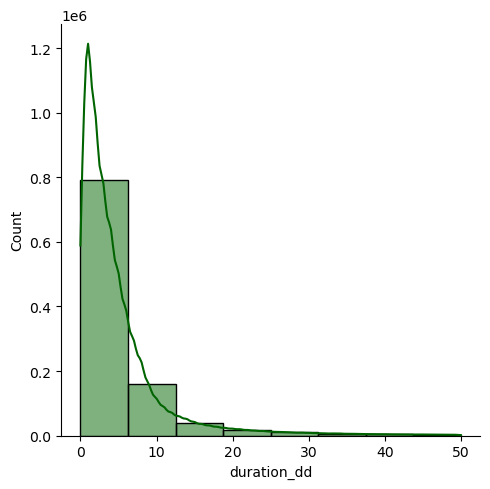

In [46]:
sns.displot(features[features["duration_dd"]<50]['duration_dd'], bins = 8, kde = True, color = 'darkgreen')
#plt.title('Durées de remboursement', fontsize=16)
plt.savefig('figure_duration_ddII.png')
plt.show()

In [23]:
print(np.median(features['duration_dd']))
print(np.mean(features['duration_dd']))

3.103328479513889
6.521051185119046


In [149]:
def yule(data):
    if len(data) == 0:
        return np.nan
    Q1 = np.percentile(data, 25)
    Q2 = np.median(data)  # Médiane
    Q3 = np.percentile(data, 75)
    numerator = (Q3 - Q2) - (Q2 - Q1)
    denominator = (Q3 - Q2) + (Q2 - Q1)
    if denominator == 0:
        return np.nan
    skewness = numerator / denominator
    return skewness

In [152]:
yuleI = yule(features['duration_dd'])
print(np.round(yuleI, 4))

0.262


In [14]:
statistic, p_value = kstest(features['duration_dd'], 'norm')

print(f"Statistique du test (D-value) : {statistic}")
print(f"p-value : {p_value}")
alpha = 0.05
print("\n--- Interprétation ---")
if p_value > alpha:
    print("On ne peut pas rejeter l'hypothèse nulle. La variable suit une distribution normale.")
else:
    print("On rejette l'hypothèse nulle. La variable ne suit probablement pas une distribution normale.")

Statistique du test (D-value) : 0.6639914260085886
p-value : 0.0

--- Interprétation ---
On rejette l'hypothèse nulle. La variable ne suit probablement pas une distribution normale.


## III - ANALYSE BIVARIEE

### III- 1- VARIABLES QUAL VS VARIABLES QUAL

#### denomination vs loan_channel

In [139]:
tabI = pd.crosstab(features['denomination'], features['loan_channel'])
chi2_stat, p_value, ddl, effectifs_theoriques = chi2_contingency(tabI)
p_value

0.0

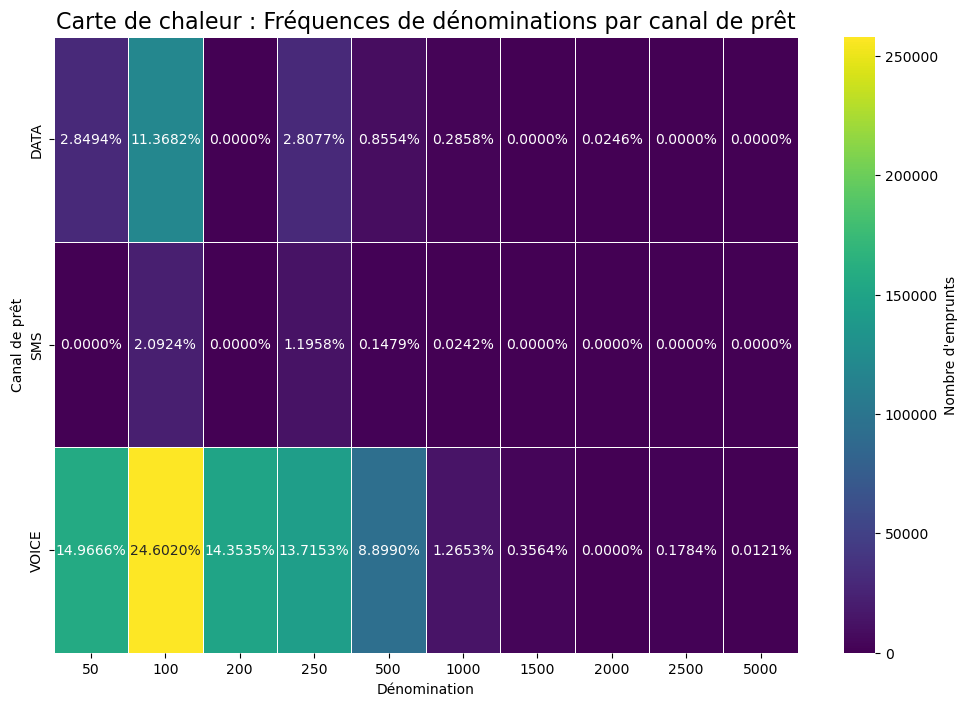

In [44]:
features['denomination'] = features['denomination'].astype('category')
features['loan_channel'] = features['loan_channel'].astype('category')
contingency_table_counts = pd.crosstab(features['loan_channel'], features['denomination'], dropna=False)
contingency_table_percentages = pd.crosstab(
    features['loan_channel'], 
    features['denomination'], 
    normalize='all',
    dropna=False
) * 100
annot_data = contingency_table_percentages.apply(lambda x: x.map(lambda y: f'{y:.4f}%'))
plt.figure(figsize=(12, 8))
sns.heatmap(
    contingency_table_counts,
    annot=annot_data,
    fmt="",
    cmap='viridis',
    linewidths=.5,
    cbar_kws={'label': 'Nombre d\'emprunts'}
)

plt.title('Carte de chaleur : Fréquences de dénominations par canal de prêt', fontsize=16)
plt.xlabel('Dénomination')
plt.ylabel('Canal de prêt')
plt.show()

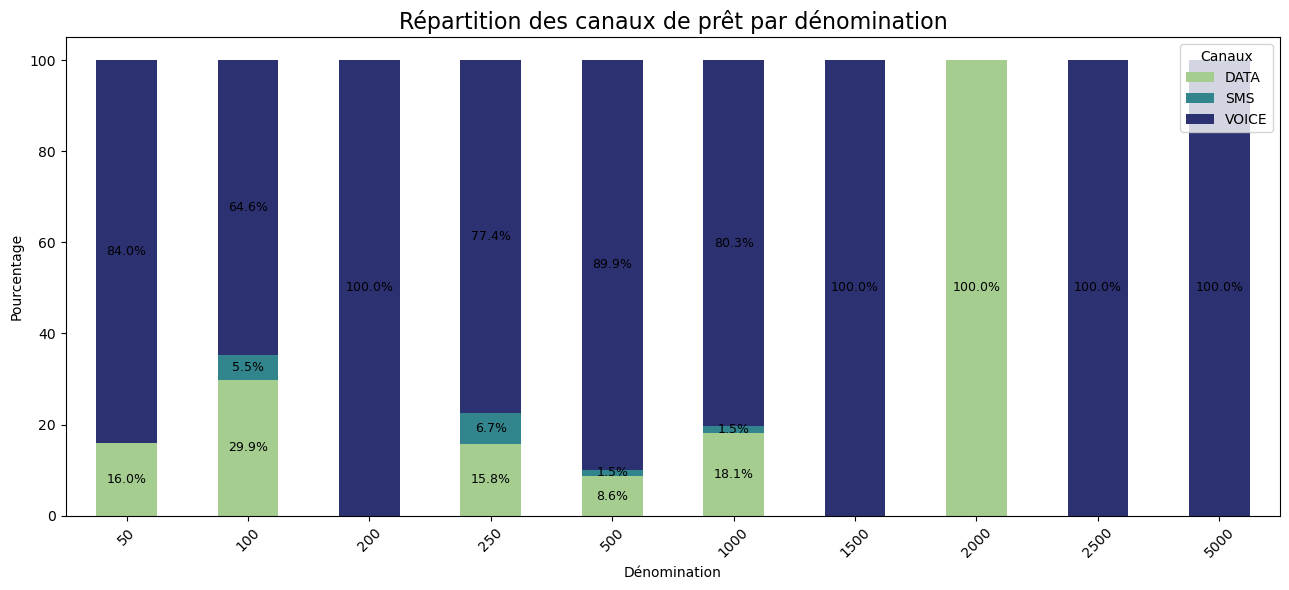

In [45]:
crosstab_norm = pd.crosstab(features['denomination'], features['loan_channel'], normalize='index') * 100
ax = crosstab_norm.plot(kind='bar', stacked=True, figsize=(13, 6), colormap='crest')
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        if height > 1:  
            ax.text(
                x = patch.get_x() + patch.get_width() / 2, # Position horizontale
                y = patch.get_y() + height / 2,            # Position verticale
                s = f'{height:.1f}%',                      
                ha = 'center',                             # Alignement horizontal
                va = 'center',                             # Alignement vertical
                fontsize = 9,
                color = 'black'
            )
plt.title('Répartition des canaux de prêt par dénomination', fontsize=16)
plt.xlabel('Dénomination')
plt.ylabel('Pourcentage')
plt.xticks(rotation=45)
plt.legend(title='Canaux')
plt.tight_layout()
plt.show()

In [140]:
print(tabI)

loan_channel    DATA    SMS   VOICE
denomination                       
50             29878      0  156936
100           119204  21940  257970
200                0      0  150507
250            29441  12539  143815
500             8969   1551   93313
1000            2997    254   13268
1500               0      0    3737
2000             258      0       0
2500               0      0    1871
5000               0      0     127


#### denomination vs day_of_week

In [141]:
tabII = pd.crosstab(features['denomination'], features['day_of_week'])
chi2_stat, p_value, ddl, effectifs_theoriques = chi2_contingency(tabII)
p_value

8.310425014336768e-49

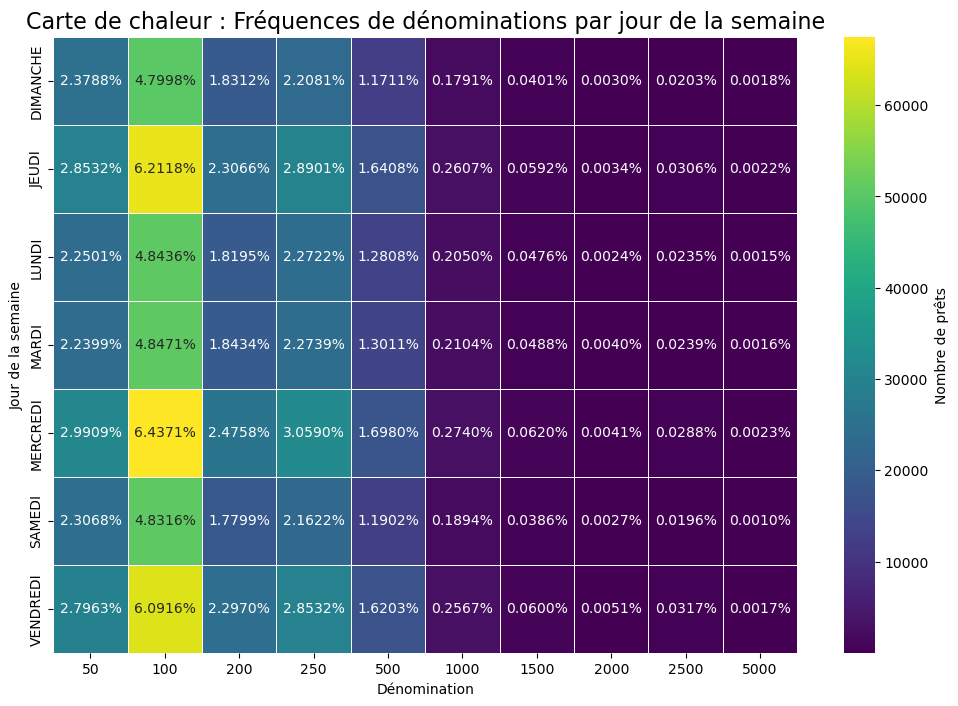

In [49]:
features['denomination'] = features['denomination'].astype('category')
features['day_of_week'] = features['day_of_week'].astype('category')
contingency_table_counts = pd.crosstab(
    features['day_of_week'],
    features['denomination'],
    dropna=False
)
contingency_table_percentages = pd.crosstab(
    features['day_of_week'],
    features['denomination'],
    normalize='all',
    dropna=False
) * 100
annot_data = contingency_table_percentages.apply(lambda x: x.map(lambda y: f'{y:.4f}%'))
plt.figure(figsize=(12, 8))

sns.heatmap(
    contingency_table_counts,
    annot=annot_data,
    fmt="",
    cmap='viridis',
    linewidths=.5,
    cbar_kws={'label': 'Nombre de prêts'}
)

plt.title('Carte de chaleur : Fréquences de dénominations par jour de la semaine', fontsize=16)
plt.xlabel('Dénomination')
plt.ylabel('Jour de la semaine')
plt.show()

#### denomination vs period_of_week

In [142]:
tabIII = pd.crosstab(features['denomination'], features['period_of_week'])
chi2_stat, p_value, ddl, effectifs_theoriques = chi2_contingency(tabIII)
p_value

6.922403305554676e-61

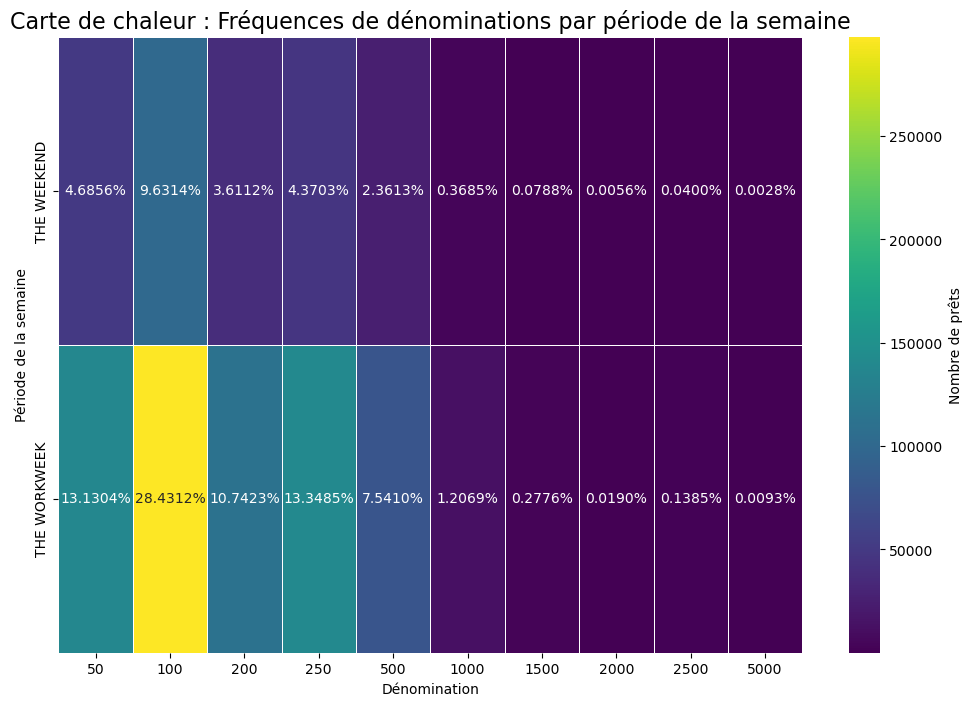

In [50]:
features['denomination'] = features['denomination'].astype('category')
features['period_of_week'] = features['period_of_week'].astype('category')
contingency_table_counts = pd.crosstab(
    features['period_of_week'],
    features['denomination'],
    dropna=False
)
contingency_table_percentages = pd.crosstab(
    features['period_of_week'],
    features['denomination'],
    normalize='all',
    dropna=False
) * 100
annot_data = contingency_table_percentages.apply(lambda x: x.map(lambda y: f'{y:.4f}%'))
plt.figure(figsize=(12, 8))

sns.heatmap(
    contingency_table_counts,
    annot=annot_data,
    fmt="",
    cmap='viridis',
    linewidths=.5,
    cbar_kws={'label': 'Nombre de prêts'}
)
plt.title('Carte de chaleur : Fréquences de dénominations par période de la semaine', fontsize=16)
plt.xlabel('Dénomination')
plt.ylabel('Période de la semaine')
plt.show()

#### denomination vs period_of_month

In [143]:
tabIV = pd.crosstab(features['denomination'], features['period_of_month'])
chi2_stat, p_value, ddl, effectifs_theoriques = chi2_contingency(tabIV)
p_value

0.008845910971543384

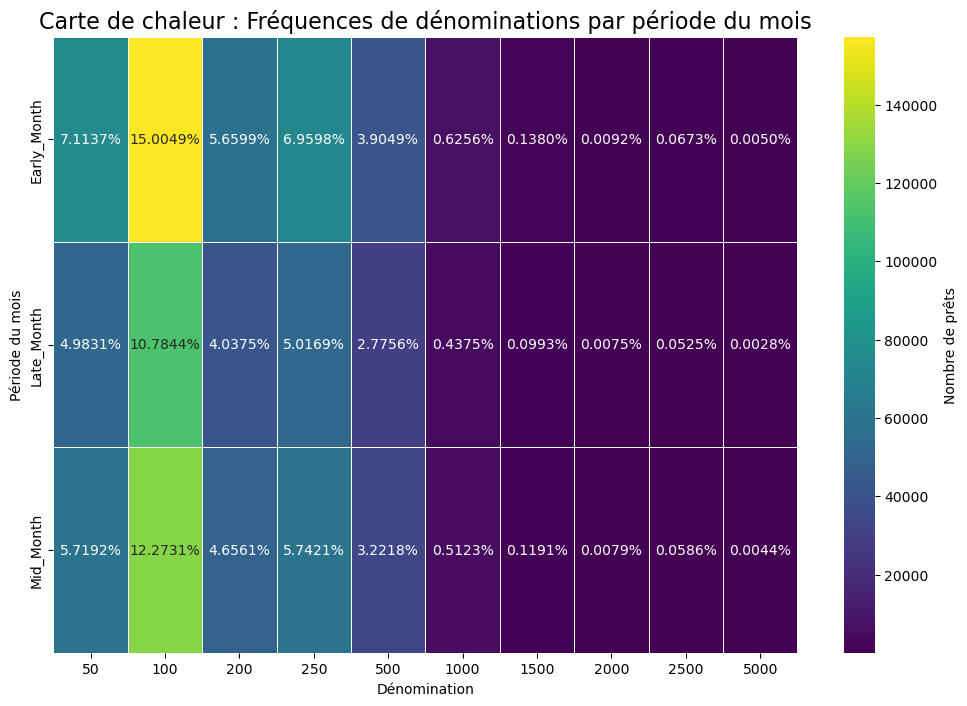

In [51]:
features['denomination'] = features['denomination'].astype('category')
features['period_of_month'] = features['period_of_month'].astype('category')
contingency_table_counts = pd.crosstab(
    features['period_of_month'],
    features['denomination'],
    dropna=False
)
contingency_table_percentages = pd.crosstab(
    features['period_of_month'],
    features['denomination'],
    normalize='all',
    dropna=False
) * 100
annot_data = contingency_table_percentages.apply(lambda x: x.map(lambda y: f'{y:.4f}%'))
plt.figure(figsize=(12, 8))

sns.heatmap(
    contingency_table_counts,
    annot=annot_data,
    fmt="",
    cmap='viridis',
    linewidths=.5,
    cbar_kws={'label': 'Nombre de prêts'}
)
plt.title('Carte de chaleur : Fréquences de dénominations par période du mois', fontsize=16)
plt.xlabel('Dénomination')
plt.ylabel('Période du mois')
plt.show()

#### loan_channel vs day_of_week

In [144]:
ItabI = pd.crosstab(features['loan_channel'], features['day_of_week'])
chi2_stat, p_value, ddl, effectifs_theoriques = chi2_contingency(ItabI)
p_value

1.3660472786090462e-06

<Figure size 1000x1000 with 0 Axes>

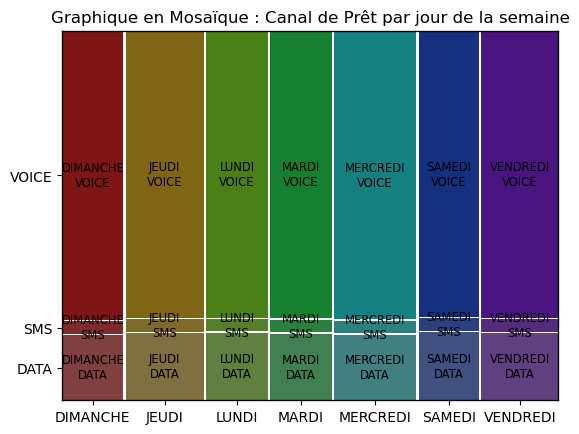

In [52]:
contingency_table = pd.crosstab(features['day_of_week'], features['loan_channel'])
plt.figure(figsize=(10, 10))
mosaic(contingency_table.stack(), title='Graphique en Mosaïque : Canal de Prêt par jour de la semaine')
plt.show()

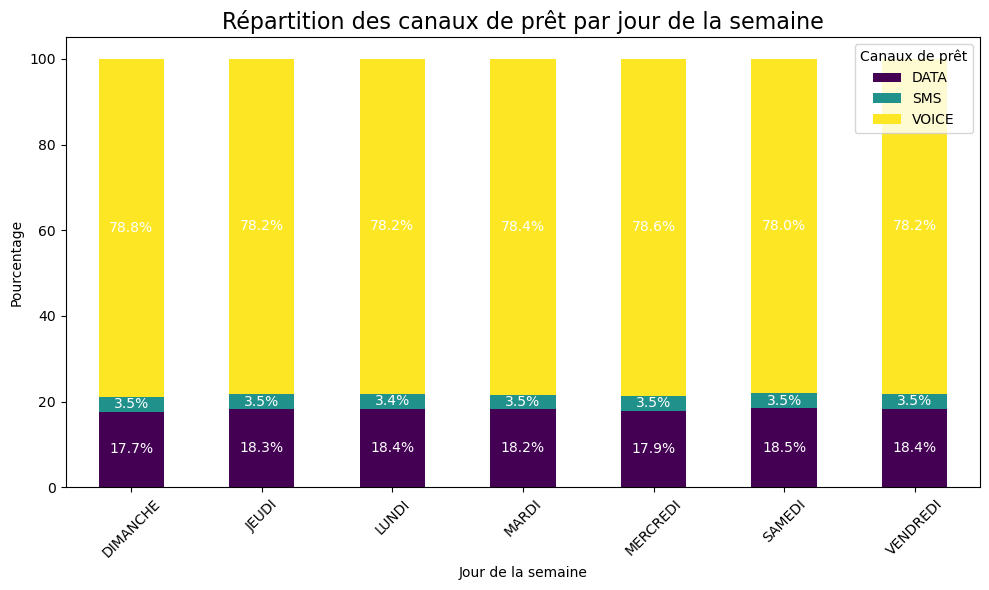

In [61]:
contingency_table_norm = pd.crosstab(features['day_of_week'], features['loan_channel'], normalize='index') * 100
ax = contingency_table_norm.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        if height > 1: 
            ax.text(
                x = patch.get_x() + patch.get_width() / 2, 
                y = patch.get_y() + height / 2,
                s = f'{height:.1f}%', 
                ha = 'center', 
                va = 'center',
                fontsize = 10,
                color = 'white'
            )

plt.title('Répartition des canaux de prêt par jour de la semaine', fontsize=16)
plt.xlabel('Jour de la semaine')
plt.ylabel('Pourcentage')
plt.xticks(rotation=45)
plt.legend(title='Canaux de prêt')
plt.tight_layout()
plt.show()

#### loan_channel vs period_of_week

In [145]:
ItabII = pd.crosstab(features['loan_channel'], features['period_of_week'])
chi2_stat, p_value, ddl, effectifs_theoriques = chi2_contingency(ItabII)
p_value

0.45484783681068097

<Figure size 1000x1000 with 0 Axes>

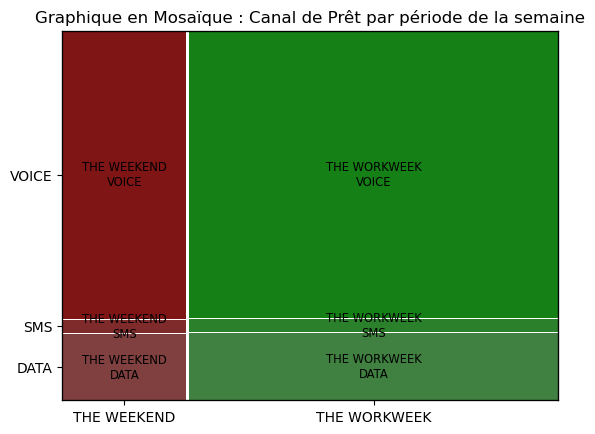

In [53]:
contingency_table = pd.crosstab(features['period_of_week'], features['loan_channel'])
plt.figure(figsize=(10, 10))
mosaic(contingency_table.stack(), title='Graphique en Mosaïque : Canal de Prêt par période de la semaine')
plt.show()

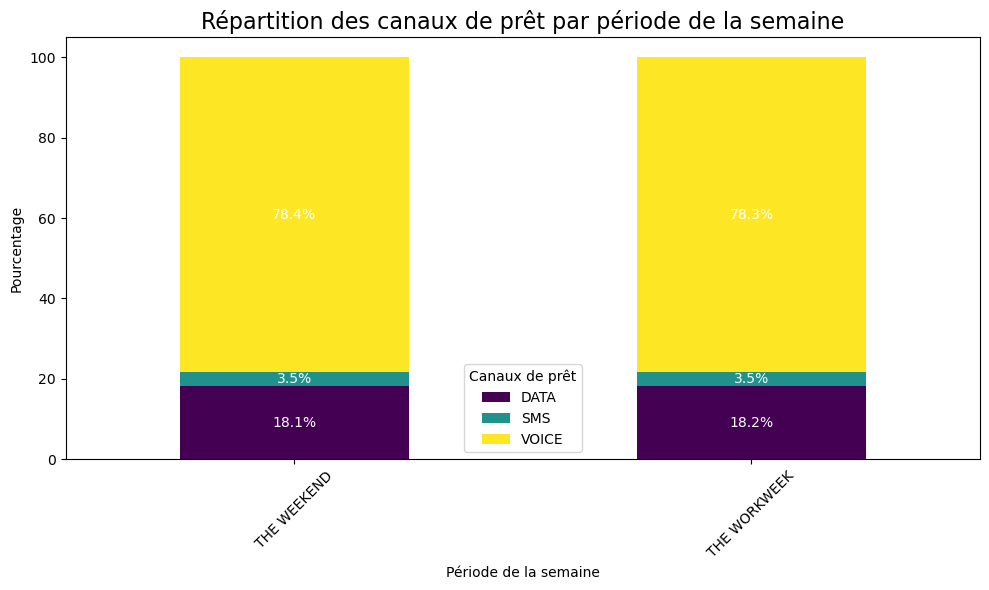

In [60]:
contingency_table_norm = pd.crosstab(features['period_of_week'], features['loan_channel'], normalize='index') * 100
ax = contingency_table_norm.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        if height > 1: 
            ax.text(
                x = patch.get_x() + patch.get_width() / 2, 
                y = patch.get_y() + height / 2,
                s = f'{height:.1f}%', 
                ha = 'center', 
                va = 'center',
                fontsize = 10,
                color = 'white'
            )

plt.title('Répartition des canaux de prêt par période de la semaine', fontsize=16)
plt.xlabel('Période de la semaine')
plt.ylabel('Pourcentage')
plt.xticks(rotation=45)
plt.legend(title='Canaux de prêt')
plt.tight_layout()
plt.show()

#### loan_channel vs period_of_month

In [146]:
ItabIII = pd.crosstab(features['loan_channel'], features['period_of_month'])
chi2_stat, p_value, ddl, effectifs_theoriques = chi2_contingency(ItabIII)
p_value

0.5056445318073766

<Figure size 1000x1000 with 0 Axes>

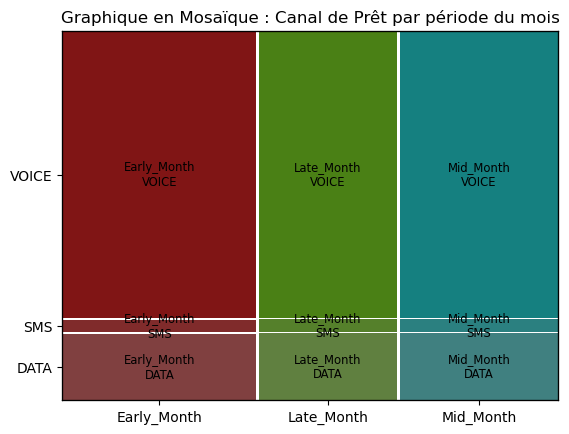

In [54]:
contingency_table = pd.crosstab(features['period_of_month'], features['loan_channel'])
plt.figure(figsize=(10, 10))
mosaic(contingency_table.stack(), title='Graphique en Mosaïque : Canal de Prêt par période du mois')
plt.show()

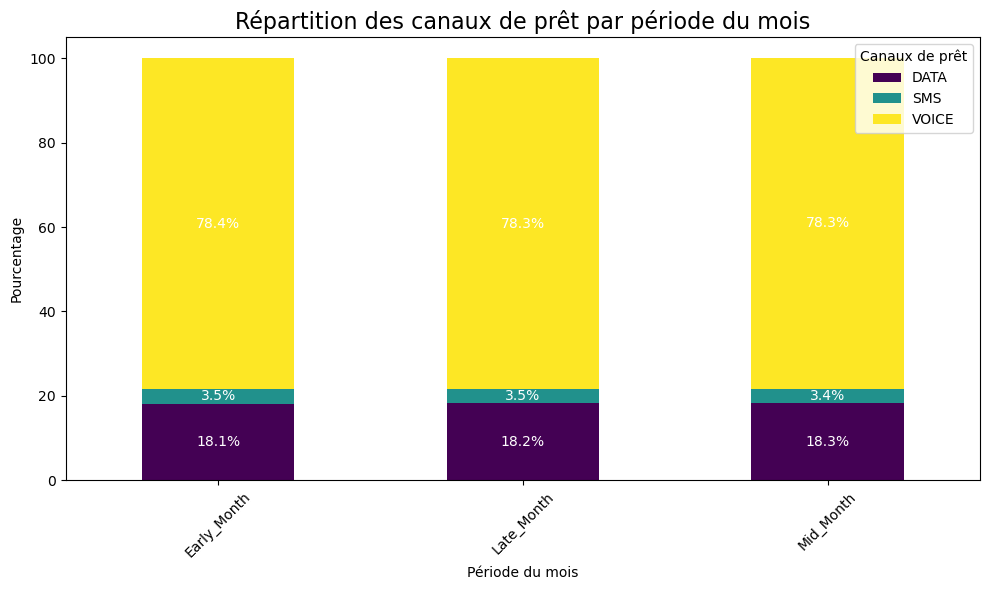

In [59]:
contingency_table_norm = pd.crosstab(features['period_of_month'], features['loan_channel'], normalize='index') * 100
ax = contingency_table_norm.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        if height > 1: 
            ax.text(
                x = patch.get_x() + patch.get_width() / 2, 
                y = patch.get_y() + height / 2,
                s = f'{height:.1f}%', 
                ha = 'center', 
                va = 'center',
                fontsize = 10,
                color = 'white'
            )

plt.title('Répartition des canaux de prêt par période du mois', fontsize=16)
plt.xlabel('Période du mois')
plt.ylabel('Pourcentage')
plt.xticks(rotation=45)
plt.legend(title='Canaux de prêt')
plt.tight_layout()
plt.show()

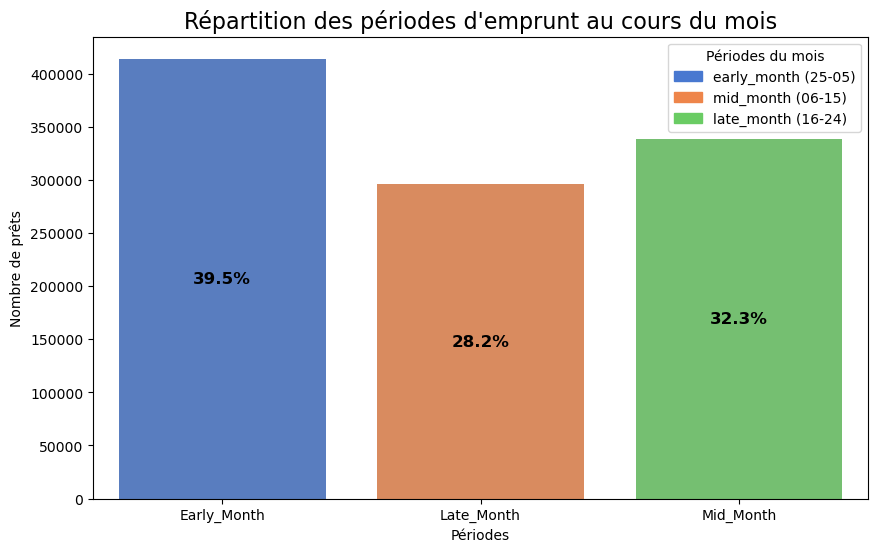

In [70]:
denomination_counts = features['period_of_month'].value_counts()
total_count = len(features['period_of_month'])

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=denomination_counts.index, y=denomination_counts.values, palette='muted')

for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        percentage = (height / total_count) * 100
        ax.text(patch.get_x() + patch.get_width() / 2, height / 2,
                f'{percentage:.1f}%',
                ha = 'center', va = 'center',
                fontsize = 12, color = 'black', weight = 'bold')
early_patch = mpatches.Patch(color=sns.color_palette('muted')[0], label='early_month (25-05)')
mid_patch = mpatches.Patch(color=sns.color_palette('muted')[1], label='mid_month (06-15)')
late_patch = mpatches.Patch(color=sns.color_palette('muted')[2], label='late_month (16-24)')
plt.legend(handles=[early_patch, mid_patch, late_patch], title='Périodes du mois')
plt.title('Répartition des périodes d\'emprunt au cours du mois', fontsize=16)
plt.xlabel('Périodes')
plt.ylabel("Nombre de prêts")

plt.show()

### III - 2- VARIABLES QUAL VS VARIABLES QUANT

#### loan_channel vs duration_dd

In [156]:
loan_channels = features['loan_channel'].unique()

for channel in loan_channels:
    data_for_channel = features[features['loan_channel'] == channel]['duration_dd'].dropna()
    if len(data_for_channel) > 3:
        stat, p_value = shapiro(data_for_channel)
        print(f"Canal de prêt: {channel}")
        print(f"  Statistique W : {stat:.4f}")
        print(f"  Valeur p : {p_value:.4f}")
        
        if p_value < 0.05:
            print("  Conclusion : On rejette H0. La distribution n'est probablement pas normale.\n")
        else:
            print("  Conclusion : On ne rejette pas H0. La distribution est probablement normale.\n")
    else:
        print(f"Canal de prêt: {channel}")
        print("  Données insuffisantes pour effectuer le test.\n")

Canal de prêt: VOICE
  Statistique W : 0.2965
  Valeur p : 0.0000
  Conclusion : On rejette H0. La distribution n'est probablement pas normale.

Canal de prêt: DATA
  Statistique W : 0.2904
  Valeur p : 0.0000
  Conclusion : On rejette H0. La distribution n'est probablement pas normale.

Canal de prêt: SMS
  Statistique W : 0.3046
  Valeur p : 0.0000
  Conclusion : On rejette H0. La distribution n'est probablement pas normale.



In [11]:
stats_par_loan_channel = features.groupby('loan_channel')['duration_dd'].agg([
    'mean',
    lambda x: x.quantile(0.10),
    lambda x: x.quantile(0.25),
    lambda x: x.quantile(0.50),
    lambda x: x.quantile(0.75),
    lambda x: x.quantile(0.90),
    lambda x: x.quantile(0.95),
    lambda x: x.quantile(0.99)
]).rename(columns={
    '<lambda_0>': 'p10',
    '<lambda_1>': 'p25',
    '<lambda_2>': 'p50',
    '<lambda_3>': 'p75',
    '<lambda_4>': 'p90',
    '<lambda_5>': 'p95',
    '<lambda_6>': 'p99'
})

stats_par_loan_channel.head()

mean       p10       p25       p50       p75        p90  \
loan_channel                                                                
DATA          6.093872  0.505392  1.114134  2.854239  5.792159  10.954149   
SMS           6.374352  0.657822  1.382766  3.159222  6.238816  11.408078   
VOICE         6.626713  0.614379  1.397423  3.178256  6.237333  11.909858   

                    p95        p99  
loan_channel                        
DATA          18.964302  65.829936  
SMS           19.046809  65.013141  
VOICE         20.025614  70.224870

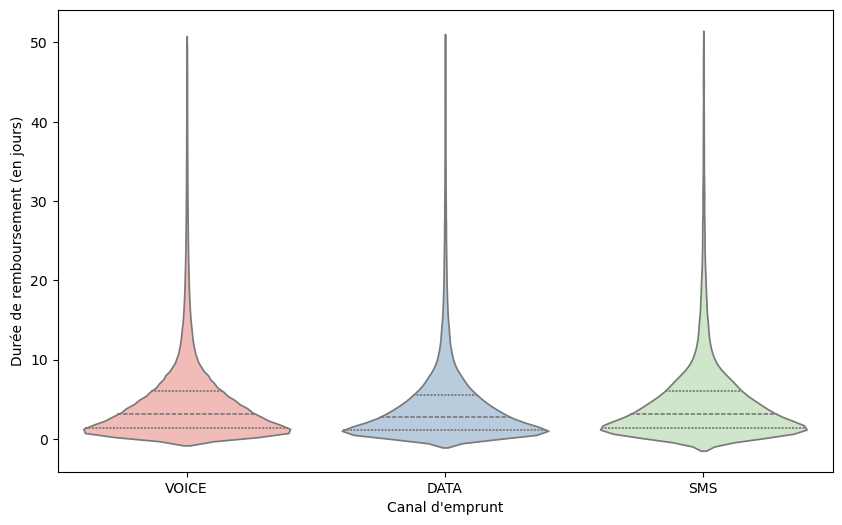

In [17]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='loan_channel', y='duration_dd', data=features[features['duration_dd'] < 50], palette='Pastel1', inner='quartile')
#plt.title('Dispersion des durées de remboursement par canal d\'emprunt', fontsize=16)
plt.xlabel('Canal d\'emprunt')
plt.ylabel('Durée de remboursement (en jours)')
plt.savefig('loan_channel_duration_dd.png', dpi = 300)
plt.show()

In [5]:
groups_data = {channel: features[features['loan_channel'] == channel]['duration_dd'].dropna() 
               for channel in features['loan_channel'].unique()}

print("--- Résultats du test de Kolmogorov-Smirnov pour la normalité de 'duration_dd' ---")
print("H0: La distribution est normale.")
print("H1: La distribution n'est pas normale.\n")

for channel, data in groups_data.items():
    if len(data) > 0:
        normalized_data = (data - data.mean()) / data.std()
        statistic, p_value = kstest(normalized_data, 'norm')
        print(f"Canal de prêt: {channel}")
        print(f"  Statistique D : {statistic:.4f}")
        print(f"  Valeur p : {p_value:.4f}")
        if p_value < 0.05:
            print("  Conclusion : On rejette H0. La distribution n'est pas normale.\n")
        else:
            print("  Conclusion : On ne rejette pas H0. La distribution est probablement normale.\n")
    else:
        print(f"Canal de prêt: {channel}")
        print("  Données insuffisantes pour effectuer le test.\n")

--- Résultats du test de Kolmogorov-Smirnov pour la normalité de 'duration_dd' ---
H0: La distribution est normale.
H1: La distribution n'est pas normale.

Canal de prêt: VOICE
  Statistique D : 0.3435
  Valeur p : 0.0000
  Conclusion : On rejette H0. La distribution n'est pas normale.

Canal de prêt: DATA
  Statistique D : 0.3488
  Valeur p : 0.0000
  Conclusion : On rejette H0. La distribution n'est pas normale.

Canal de prêt: SMS
  Statistique D : 0.3377
  Valeur p : 0.0000
  Conclusion : On rejette H0. La distribution n'est pas normale.



In [6]:
groups = [features[features['loan_channel'] == channel]['duration_dd'].dropna() 
          for channel in features['loan_channel'].unique()]

print("--- Résultats du test de Kruskal-Wallis H ---")
print("H0: Les distributions de 'duration_dd' sont identiques pour tous les canaux.")
print("H1: Au moins une distribution est différente.\n")
try:
    statistic, p_value = kruskal(*groups)
    print(f"Statistique H : {statistic:.4f}")
    print(f"Valeur p : {p_value:.4f}")
    alpha = 0.05
    if p_value < alpha:
        print(f"\nConclusion : On rejette H0 (p < {alpha}). Il y a une différence significative dans les durées de remboursement entre les canaux de prêt.")
    else:
        print(f"\nConclusion : On ne rejette pas H0 (p >= {alpha}). Il n'y a pas de différence significative dans les durées de remboursement.")
        
except ValueError:
    print("\nErreur : Un des groupes de données est vide ou contient trop peu de valeurs non manquantes.")

--- Résultats du test de Kruskal-Wallis H ---
H0: Les distributions de 'duration_dd' sont identiques pour tous les canaux.
H1: Au moins une distribution est différente.

Statistique H : 1982.0599
Valeur p : 0.0000

Conclusion : On rejette H0 (p < 0.05). Il y a une différence significative dans les durées de remboursement entre les canaux de prêt.


In [19]:
import scikit_posthocs as sp
#pip install scikit-posthocs
groups_data = [group['duration_dd'].dropna() for name, group in features.groupby('loan_channel')]
dunn_result = sp.posthoc_dunn(
    a=groups_data,
    p_adjust='bonferroni'  
)
channels = features['loan_channel'].unique()
dunn_result.columns = channels
dunn_result.index = channels

print("--- Résultat du test post-hoc de Dunn ---")
print("Valeurs p ajustées (correction de Bonferroni)\n")
print(dunn_result)

# 4. Interprétation
print("\n--- Interprétation ---")
print("Si la valeur p est inférieure à 0.05, la différence entre les deux groupes est significative.")

--- Résultat du test post-hoc de Dunn ---
Valeurs p ajustées (correction de Bonferroni)

              VOICE          DATA  SMS
VOICE  1.000000e+00  1.080460e-80  0.0
DATA   1.080460e-80  1.000000e+00  1.0
SMS    0.000000e+00  1.000000e+00  1.0

--- Interprétation ---
Si la valeur p est inférieure à 0.05, la différence entre les deux groupes est significative.


In [40]:
groups = [features[features['loan_channel'] == channel]['duration_dd'].dropna() 
          for channel in features['loan_channel'].unique()]
try:
    statistic, p_value = kruskal(*groups)
    print(f"Statistique H : {statistic:.4f}")
    print(f"Valeur p : {p_value:.4f}")
    alpha = 0.05
    if p_value < alpha:
        print(f"\nConclusion : On rejette H0 (p < {alpha}). Il y a une différence significative dans les durées de remboursement entre les canaux de prêt.")
    else:
        print(f"\nConclusion : On ne rejette pas H0 (p >= {alpha}). Il n'y a pas de différence significative dans les durées de remboursement.")
        
except ValueError:
    print("\nErreur : Un des groupes de données est vide ou contient trop peu de valeurs non manquantes.")

Statistique H : 1982.0599
Valeur p : 0.0000

Conclusion : On rejette H0 (p < 0.05). Il y a une différence significative dans les durées de remboursement entre les canaux de prêt.


In [43]:
groups_data = [group['duration_dd'].dropna() for name, group in features.groupby('loan_channel')]

dunn_result = sp.posthoc_dunn(
    a=groups_data,
    p_adjust='bonferroni'  
)

channels = features['loan_channel'].unique()
dunn_result.columns = channels
dunn_result.index = channels

print("--- Résultat du test post-hoc de Dunn ---")
print(dunn_result)

# 4. Interprétation
print("\n--- Interprétation ---")
print("Si la valeur p est inférieure à 0.05, la différence entre les deux groupes est significative.")

--- Résultat du test post-hoc de Dunn ---
              VOICE          DATA  SMS
VOICE  1.000000e+00  1.080460e-80  0.0
DATA   1.080460e-80  1.000000e+00  1.0
SMS    0.000000e+00  1.000000e+00  1.0

--- Interprétation ---
Si la valeur p est inférieure à 0.05, la différence entre les deux groupes est significative.


#### denomination vs duration_dd

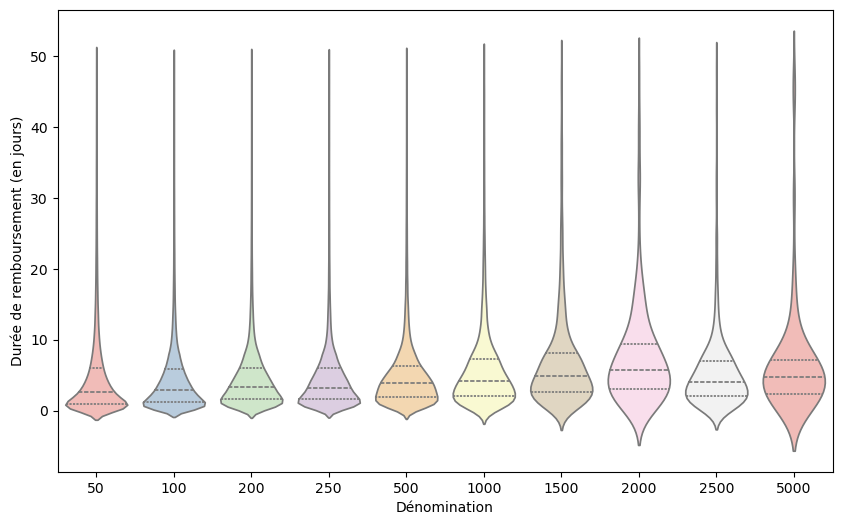

In [20]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='denomination', y='duration_dd', data=features[features['duration_dd'] < 50], palette='Pastel1', inner='quartile')
#plt.title('Dispersion des durées de remboursement par dénomination', fontsize=16)
plt.xlabel('Dénomination')
plt.ylabel('Durée de remboursement (en jours)')
plt.savefig('denomination_duration_dd.png', dpi = 300)
plt.show()

In [15]:
stats_par_denomination = features.groupby('denomination')['duration_dd'].agg([
    'mean',
    lambda x: x.quantile(0.10),
    lambda x: x.quantile(0.25),
    lambda x: x.quantile(0.50),
    lambda x: x.quantile(0.75),
    lambda x: x.quantile(0.90),
    lambda x: x.quantile(0.95),
    lambda x: x.quantile(0.99)
]).rename(columns={
    '<lambda_0>': 'p10',
    '<lambda_1>': 'p25',
    '<lambda_2>': 'p50',
    '<lambda_3>': 'p75',
    '<lambda_4>': 'p90',
    '<lambda_5>': 'p95',
    '<lambda_6>': 'p99'
})

stats_par_denomination.head(10)

mean       p10       p25       p50       p75        p90  \
denomination                                                                 
50             7.812625  0.300250  0.971817  2.737671  6.640362  15.912706   
100            6.004542  0.498507  1.168172  2.939808  5.949520  11.066679   
200            6.015452  0.847432  1.673055  3.381713  6.140141  10.547308   
250            6.247114  0.832722  1.591514  3.295901  6.037142  10.257962   
500            7.027458  0.974688  1.965680  3.884948  6.551970  11.744733   
1000           7.979380  1.010781  2.076100  4.183118  7.587867  14.055208   
1500          10.004730  1.138479  2.644631  4.996279  8.539706  16.965849   
2000           7.712495  1.146893  3.076817  5.706676  9.501209  15.251268   
2500           7.435795  0.956157  2.026397  4.061247  7.116445  11.401482   
5000           7.664516  1.031523  2.353762  4.783444  7.182255  12.311530   

                    p95         p99  
denomination                         
50            28.853233   98.239952  
100           18.289144   60.018787  
200           16.585620   53.908872  
250           16.925831   62.850226  
500           19.775387   71.130873  
1000          22.859240   84.787050  
1500          28.825969  127.622061  
2000          19.958150   40.593611  
2500          18.733078   75.082460  
5000          20.892227   46.806321

In [22]:
groups_data = {deno: features[features['denomination'] == deno]['duration_dd'].dropna() 
               for deno in features['denomination'].unique()}
print("--- Résultats du test de Kolmogorov-Smirnov pour la normalité de 'duration_dd' ---")
for deno, data in groups_data.items():
    if len(data) > 0:
        normalized_data = (data - data.mean()) / data.std()
        statistic, p_value = kstest(normalized_data, 'norm')
        print(f"Canal de prêt: {deno}")
        print(f"  Statistique D : {statistic:.4f}")
        print(f"  Valeur p : {p_value:.4f}")
        if p_value < 0.05:
            print("  Conclusion : On rejette H0. La distribution n'est pas normale.\n")
        else:
            print("  Conclusion : On ne rejette pas H0. La distribution est probablement normale.\n")
    else:
        print(f"Canal de prêt: {deno}")
        print("  Données insuffisantes pour effectuer le test.\n")

--- Résultats du test de Kolmogorov-Smirnov pour la normalité de 'duration_dd' ---
Canal de prêt: 50
  Statistique D : 0.3502
  Valeur p : 0.0000
  Conclusion : On rejette H0. La distribution n'est pas normale.

Canal de prêt: 250
  Statistique D : 0.3460
  Valeur p : 0.0000
  Conclusion : On rejette H0. La distribution n'est pas normale.

Canal de prêt: 100
  Statistique D : 0.3424
  Valeur p : 0.0000
  Conclusion : On rejette H0. La distribution n'est pas normale.

Canal de prêt: 1000
  Statistique D : 0.3288
  Valeur p : 0.0000
  Conclusion : On rejette H0. La distribution n'est pas normale.

Canal de prêt: 200
  Statistique D : 0.3299
  Valeur p : 0.0000
  Conclusion : On rejette H0. La distribution n'est pas normale.

Canal de prêt: 500
  Statistique D : 0.3400
  Valeur p : 0.0000
  Conclusion : On rejette H0. La distribution n'est pas normale.

Canal de prêt: 2500
  Statistique D : 0.3507
  Valeur p : 0.0000
  Conclusion : On rejette H0. La distribution n'est pas normale.

Canal 

In [29]:
groups = [features[features['denomination'] == deno]['duration_dd'].dropna() 
          for deno in features['denomination'].unique()]
print("--- Résultats du test de Kruskal-Wallis H ---")
print("H0: Les distributions de 'duration_dd' sont identiques pour toutes les denominations.")
print("H1: Au moins une distribution est différente.\n")
try:
    statistic, p_value = kruskal(*groups)
    print(f"Statistique H : {statistic:.4f}")
    print(f"Valeur p : {p_value:.4f}")
    alpha = 0.05
    if p_value < alpha:
        print(f"\nConclusion : On rejette H0 (p < {alpha}). Il y a une différence significative dans les durées de remboursement entre les denominations.")
    else:
        print(f"\nConclusion : On ne rejette pas H0 (p >= {alpha}). Il n'y a pas de différence significative dans les durées de remboursement.")
        
except ValueError:
    print("\nErreur : Un des groupes de données est vide ou contient trop peu de valeurs non manquantes.")

--- Résultats du test de Kruskal-Wallis H ---
H0: Les distributions de 'duration_dd' sont identiques pour toutes les denominations.
H1: Au moins une distribution est différente.

Statistique H : 9902.6267
Valeur p : 0.0000

Conclusion : On rejette H0 (p < 0.05). Il y a une différence significative dans les durées de remboursement entre les denominations.


In [5]:
groups_data = [group['duration_dd'].dropna() for name, group in features.groupby('denomination')]
dunn_result = sp.posthoc_dunn(
    a=groups_data,
    p_adjust='bonferroni'  
)
deno = features['denomination'].unique()
dunn_result.columns = deno
dunn_result.index = deno

print("--- Résultat du test post-hoc de Dunn ---")
print("Valeurs p ajustées (correction de Bonferroni)\n")
print(dunn_result)

# 4. Interprétation
print("\n--- Interprétation ---")
print("Si la valeur p est inférieure à 0.05, la différence entre les deux groupes est significative.")

--- Résultat du test post-hoc de Dunn ---
Valeurs p ajustées (correction de Bonferroni)

               50             250            100            1000  \
50     1.000000e+00   1.551719e-30   0.000000e+00   0.000000e+00   
250    1.551719e-30   1.000000e+00   0.000000e+00   0.000000e+00   
100    0.000000e+00   0.000000e+00   1.000000e+00   7.994635e-08   
1000   0.000000e+00   0.000000e+00   7.994635e-08   1.000000e+00   
200    0.000000e+00   0.000000e+00  3.990185e-157  4.715477e-242   
500    0.000000e+00   0.000000e+00  1.632289e-142  1.614299e-175   
2500  6.252112e-220  3.768779e-195  8.137666e-103  1.357616e-115   
5000   6.397355e-21   1.025690e-18   4.914911e-11   4.060979e-12   
1500   3.014153e-42   3.192600e-34   6.050063e-10   7.755255e-13   
2000   2.098157e-05   1.371571e-04   6.749155e-02   2.922817e-02   

               200            500            2500          5000          1500  \
50     0.000000e+00   0.000000e+00  6.252112e-220  6.397355e-21  3.014153e-42   


In [16]:
stats_par_denomination.to_csv('percentile_denomination.csv', index=False, sep=';')

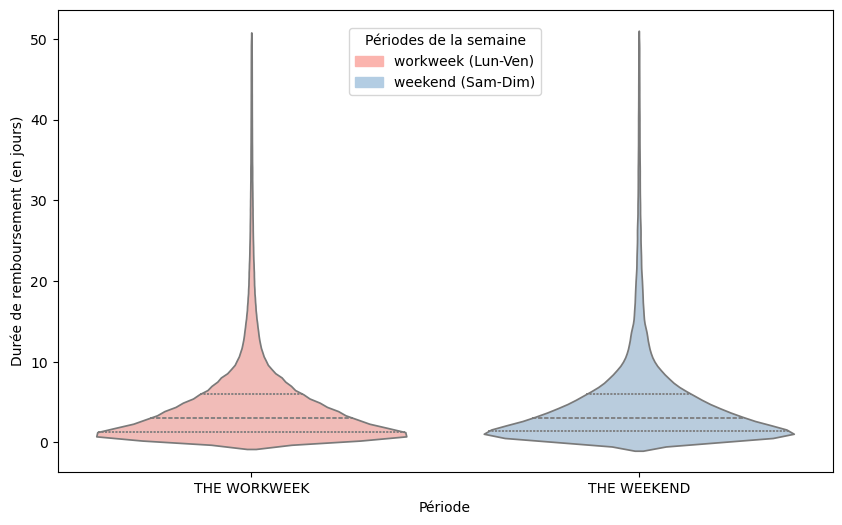

In [38]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='period_of_week', y='duration_dd', data=features[features['duration_dd'] < 50], palette='Pastel1', inner='quartile')
#plt.title('Dispersion des durées de remboursement par période de la semaine', fontsize=16)
plt.xlabel('Période')
plt.ylabel('Durée de remboursement (en jours)')
workweek_patch = mpatches.Patch(color=sns.color_palette('Pastel1')[0], label='workweek (Lun-Ven)')
weekend_patch = mpatches.Patch(color=sns.color_palette('Pastel1')[1], label='weekend (Sam-Dim)')
plt.legend(handles=[workweek_patch, weekend_patch], title='Périodes de la semaine', bbox_to_anchor=(0.5, 0.8))
plt.savefig('pow_duration_dd.png', dpi=300)
plt.show()

In [12]:
stats_par_period_of_week = features.groupby('period_of_week')['duration_dd'].agg([
    'mean',
    lambda x: x.quantile(0.10),
    lambda x: x.quantile(0.25),
    lambda x: x.quantile(0.50),
    lambda x: x.quantile(0.75),
    lambda x: x.quantile(0.90),
    lambda x: x.quantile(0.95),
    lambda x: x.quantile(0.99)
]).rename(columns={
    '<lambda_0>': 'p10',
    '<lambda_1>': 'p25',
    '<lambda_2>': 'p50',
    '<lambda_3>': 'p75',
    '<lambda_4>': 'p90',
    '<lambda_5>': 'p95',
    '<lambda_6>': 'p99'
})

stats_par_period_of_week.head(10)

mean       p10       p25       p50       p75        p90  \
period_of_week                                                                
THE WEEKEND     6.584516  0.608556  1.386615  3.107718  6.156578  11.986404   
THE WORKWEEK    6.499721  0.580977  1.315697  3.102122  6.125444  11.635989   

                      p95        p99  
period_of_week                        
THE WEEKEND     20.236017  69.874435  
THE WORKWEEK    19.713752  68.988949

In [30]:
groups_data = {pow_: features[features['period_of_week'] == pow_]['duration_dd'].dropna() 
               for pow_ in features['period_of_week'].unique()}

print("--- Résultats du test de Kolmogorov-Smirnov pour la normalité de 'duration_dd' ---")
print("H0: La distribution est normale.")
print("H1: La distribution n'est pas normale.\n")

for pow_, data in groups_data.items():
    if len(data) > 0:
        normalized_data = (data - data.mean()) / data.std()
        statistic, p_value = kstest(normalized_data, 'norm')
        print(f"Canal de prêt: {pow_}")
        print(f"  Statistique D : {statistic:.4f}")
        print(f"  Valeur p : {p_value:.4f}")
        if p_value < 0.05:
            print("  Conclusion : On rejette H0. La distribution n'est pas normale.\n")
        else:
            print("  Conclusion : On ne rejette pas H0. La distribution est probablement normale.\n")
    else:
        print(f"Canal de prêt: {pow_}")
        print("  Données insuffisantes pour effectuer le test.\n")

--- Résultats du test de Kolmogorov-Smirnov pour la normalité de 'duration_dd' ---
H0: La distribution est normale.
H1: La distribution n'est pas normale.

Canal de prêt: THE WORKWEEK
  Statistique D : 0.3451
  Valeur p : 0.0000
  Conclusion : On rejette H0. La distribution n'est pas normale.

Canal de prêt: THE WEEKEND
  Statistique D : 0.3418
  Valeur p : 0.0000
  Conclusion : On rejette H0. La distribution n'est pas normale.



In [39]:
groups = [features[features['period_of_week'] == pow_]['duration_dd'].dropna() 
          for pow_ in features['period_of_week'].unique()]
print("--- Résultats du test de Kruskal-Wallis H ---")
print("H0: Les distributions de 'duration_dd' sont identiques pour toutes les denominations.")
print("H1: Au moins une distribution est différente.\n")
try:
    statistic, p_value = kruskal(*groups)
    print(f"Statistique H : {statistic:.4f}")
    print(f"Valeur p : {p_value:.4f}")
    alpha = 0.05
    if p_value < alpha:
        print(f"\nConclusion : On rejette H0 (p < {alpha}). Il y a une différence significative dans les durées de remboursement entre les denominations.")
    else:
        print(f"\nConclusion : On ne rejette pas H0 (p >= {alpha}). Il n'y a pas de différence significative dans les durées de remboursement.")
        
except ValueError:
    print("\nErreur : Un des groupes de données est vide ou contient trop peu de valeurs non manquantes.")

--- Résultats du test de Kruskal-Wallis H ---
H0: Les distributions de 'duration_dd' sont identiques pour toutes les denominations.
H1: Au moins une distribution est différente.

Statistique H : 26.0718
Valeur p : 0.0000

Conclusion : On rejette H0 (p < 0.05). Il y a une différence significative dans les durées de remboursement entre les denominations.


In [6]:
groups_data = [group['duration_dd'].dropna() for name, group in features.groupby('period_of_week')]
dunn_result = sp.posthoc_dunn(
    a=groups_data,
    p_adjust='bonferroni'  
)
pow_ = features['period_of_week'].unique()
dunn_result.columns = pow_
dunn_result.index = pow_

print("--- Résultat du test post-hoc de Dunn ---")
print("Valeurs p ajustées (correction de Bonferroni)\n")
print(dunn_result)

# 4. Interprétation
print("\n--- Interprétation ---")
print("Si la valeur p est inférieure à 0.05, la différence entre les deux groupes est significative.")

--- Résultat du test post-hoc de Dunn ---
Valeurs p ajustées (correction de Bonferroni)

              THE WORKWEEK   THE WEEKEND
THE WORKWEEK  1.000000e+00  3.289458e-07
THE WEEKEND   3.289458e-07  1.000000e+00

--- Interprétation ---
Si la valeur p est inférieure à 0.05, la différence entre les deux groupes est significative.


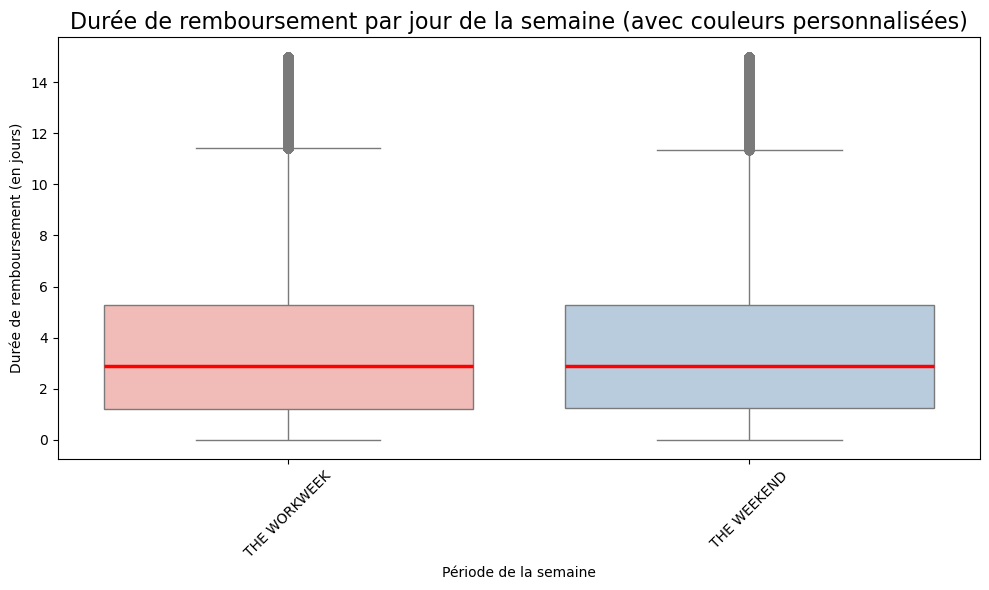

In [34]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='period_of_week', 
    y='duration_dd', 
    data=features[features['duration_dd'] <15], 
    palette='Pastel1',
    #medianprops=dict(color='red', linewidth=2.5),
    #boxprops=dict(edgecolor='blue', facecolor='lightgray', linewidth=1.5),
    #whiskerprops=dict(color='black', linewidth=1.5)
)

plt.title('Durée de remboursement par période de la semaine', fontsize=16)
plt.xlabel('Période de la semaine')
plt.ylabel('Durée de remboursement (en jours)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

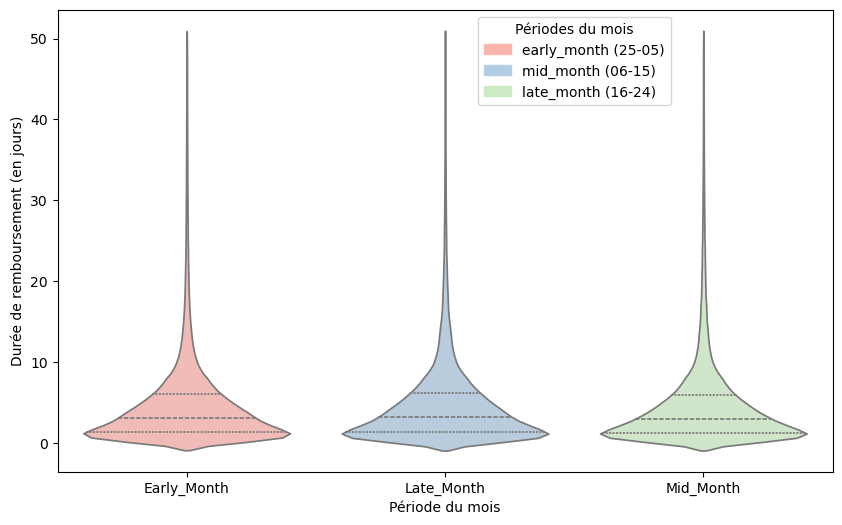

In [42]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='period_of_month', y='duration_dd', data=features[features['duration_dd'] < 50], palette='Pastel1', inner='quartile')
early_patch = mpatches.Patch(color=sns.color_palette('Pastel1')[0], label='early_month (25-05)')
mid_patch = mpatches.Patch(color=sns.color_palette('Pastel1')[1], label='mid_month (06-15)')
late_patch = mpatches.Patch(color=sns.color_palette('Pastel1')[2], label='late_month (16-24)')
plt.legend(handles=[early_patch, mid_patch, late_patch], title='Périodes du mois', bbox_to_anchor=(0.8, 1))
#plt.title('Dispersion des durées de remboursement par période du mois', fontsize=16)
plt.xlabel('Période du mois')
plt.ylabel('Durée de remboursement (en jours)')
plt.savefig('pom_duration_dd.png', dpi = 300)
plt.show()

In [13]:
stats_par_period_of_month = features.groupby('period_of_month')['duration_dd'].agg([
    'mean',
    lambda x: x.quantile(0.10),
    lambda x: x.quantile(0.25),
    lambda x: x.quantile(0.50),
    lambda x: x.quantile(0.75),
    lambda x: x.quantile(0.90),
    lambda x: x.quantile(0.95),
    lambda x: x.quantile(0.99)
]).rename(columns={
    '<lambda_0>': 'p10',
    '<lambda_1>': 'p25',
    '<lambda_2>': 'p50',
    '<lambda_3>': 'p75',
    '<lambda_4>': 'p90',
    '<lambda_5>': 'p95',
    '<lambda_6>': 'p99'
})

stats_par_period_of_month.head(10)

mean       p10       p25       p50       p75        p90  \
period_of_month                                                                
Early_Month      6.625340  0.592742  1.351018  3.135172  6.118868  11.596573   
Late_Month       6.514226  0.602572  1.385632  3.214959  6.357692  11.917684   
Mid_Month        6.399567  0.568686  1.268886  3.009882  6.016897  11.755829   

                       p95        p99  
period_of_month                        
Early_Month      20.140075  73.131614  
Late_Month       19.069683  65.738257  
Mid_Month        20.046463  67.651900

In [43]:
groups_data = {pom_: features[features['period_of_month'] == pom_]['duration_dd'].dropna() 
               for pom_ in features['period_of_month'].unique()}

print("--- Résultats du test de Kolmogorov-Smirnov pour la normalité de 'duration_dd' ---")
print("H0: La distribution est normale.")
print("H1: La distribution n'est pas normale.\n")

for pom_, data in groups_data.items():
    if len(data) > 0:
        normalized_data = (data - data.mean()) / data.std()
        statistic, p_value = kstest(normalized_data, 'norm')
        print(f"Canal de prêt: {pom_}")
        print(f"  Statistique D : {statistic:.4f}")
        print(f"  Valeur p : {p_value:.4f}")
        if p_value < 0.05:
            print("  Conclusion : On rejette H0. La distribution n'est pas normale.\n")
        else:
            print("  Conclusion : On ne rejette pas H0. La distribution est probablement normale.\n")
    else:
        print(f"Canal de prêt: {pom_}")
        print("  Données insuffisantes pour effectuer le test.\n")

--- Résultats du test de Kolmogorov-Smirnov pour la normalité de 'duration_dd' ---
H0: La distribution est normale.
H1: La distribution n'est pas normale.

Canal de prêt: Early_Month
  Statistique D : 0.3462
  Valeur p : 0.0000
  Conclusion : On rejette H0. La distribution n'est pas normale.

Canal de prêt: Late_Month
  Statistique D : 0.3407
  Valeur p : 0.0000
  Conclusion : On rejette H0. La distribution n'est pas normale.

Canal de prêt: Mid_Month
  Statistique D : 0.3449
  Valeur p : 0.0000
  Conclusion : On rejette H0. La distribution n'est pas normale.



In [44]:
groups = [features[features['period_of_month'] == pom_]['duration_dd'].dropna() 
          for pom_ in features['period_of_month'].unique()]
print("--- Résultats du test de Kruskal-Wallis H ---")
print("H0: Les distributions de 'duration_dd' sont identiques pour toutes les denominations.")
print("H1: Au moins une distribution est différente.\n")
try:
    statistic, p_value = kruskal(*groups)
    print(f"Statistique H : {statistic:.4f}")
    print(f"Valeur p : {p_value:.4f}")
    alpha = 0.05
    if p_value < alpha:
        print(f"\nConclusion : On rejette H0 (p < {alpha}). Il y a une différence significative dans les durées de remboursement entre les denominations.")
    else:
        print(f"\nConclusion : On ne rejette pas H0 (p >= {alpha}). Il n'y a pas de différence significative dans les durées de remboursement.")
        
except ValueError:
    print("\nErreur : Un des groupes de données est vide ou contient trop peu de valeurs non manquantes.")

--- Résultats du test de Kruskal-Wallis H ---
H0: Les distributions de 'duration_dd' sont identiques pour toutes les denominations.
H1: Au moins une distribution est différente.

Statistique H : 445.3084
Valeur p : 0.0000

Conclusion : On rejette H0 (p < 0.05). Il y a une différence significative dans les durées de remboursement entre les denominations.


In [7]:
groups_data = [group['duration_dd'].dropna() for name, group in features.groupby('period_of_month')]
dunn_result = sp.posthoc_dunn(
    a=groups_data,
    p_adjust='bonferroni'  
)
pom_ = features['period_of_month'].unique()
dunn_result.columns = pom_
dunn_result.index = pom_

print("--- Résultat du test post-hoc de Dunn ---")
print("Valeurs p ajustées (correction de Bonferroni)\n")
print(dunn_result)

# 4. Interprétation
print("\n--- Interprétation ---")
print("Si la valeur p est inférieure à 0.05, la différence entre les deux groupes est significative.")

--- Résultat du test post-hoc de Dunn ---
Valeurs p ajustées (correction de Bonferroni)

              Early_Month    Late_Month     Mid_Month
Early_Month  1.000000e+00  1.015241e-18  3.747037e-40
Late_Month   1.015241e-18  1.000000e+00  4.302067e-96
Mid_Month    3.747037e-40  4.302067e-96  1.000000e+00

--- Interprétation ---
Si la valeur p est inférieure à 0.05, la différence entre les deux groupes est significative.


In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

def calculer_somme(df):
    sommes = []
    colonnes_a_exclure = ['ref_date', 'interval', 'INTERVAL', 'SDATE', 'SUM_CENTS_PRINCIPAL', 'total_lending', 'total_recovery']
    colonnes_numeriques = [col for col in df.columns if col not in colonnes_a_exclure and pd.to_numeric(col, errors='coerce') is not None]
    
    df_a_calculer = df[colonnes_numeriques]
    for _, ligne in df_a_calculer.iterrows():
        somme_ligne_actuelle = 0
        for nom_colonne, valeur_cellule in ligne.items():
            valeur_entete = float(nom_colonne)
            valeur_numerique_cellule = float(valeur_cellule)
            somme_ligne_actuelle += valeur_entete * valeur_numerique_cellule
        sommes.append(somme_ligne_actuelle)
    return sommes

def montecarlo(df: pd.DataFrame) -> pd.DataFrame:
    df_sim = df.copy()
    
    # Identifier les colonnes numériques pour la simulation
    numerical_cols = df_sim.select_dtypes(include=np.number).columns
    
    # Simuler des valeurs pour chaque colonne indépendamment
    for col in numerical_cols:
        lambda_hat = df_sim[col].mean()
        df_sim[col] = np.random.poisson(lam=lambda_hat, size=len(df_sim))
        
    return df_sim

def bootstrap(df: pd.DataFrame) -> pd.DataFrame:
    df_sim = df.copy()
    
    # Rééchantillonner des lignes entières
    resampled_indices = np.random.choice(df_sim.index, size=len(df_sim), replace=True)
    df_sim = df_sim.loc[resampled_indices].reset_index(drop=True)
        
    return df_sim

def plot_simulation_trajecto(
    lending_file: str,
    recovery_file: str,
    method: str,
    num_iterations: int,
    save_to_csv: bool = False
):
    df_lending = pd.read_csv(lending_file, sep=';')
    df_recovery = pd.read_csv(recovery_file, sep=';')
    
    # Créer une copie pour ne pas altérer les DataFrames originaux
    df_lending_copy = df_lending.copy()
    df_recovery_copy = df_recovery.copy()

    df_lending_copy['total_lending'] = calculer_somme(df_lending_copy)
    df_recovery_copy['total_recovery'] = calculer_somme(df_recovery_copy)
    
    df_combined = pd.merge(df_lending_copy, df_recovery_copy, on=['ref_date', 'INTERVAL'], how='outer').fillna(0)
    df_combined['solde_cumule_original'] = df_combined['total_lending'].cumsum() - df_combined['total_recovery'].cumsum()
    
    if method.lower() == 'monte_carlo':
        simulation_func = montecarlo
        label = 'Trajectoire Monte Carlo'
        color = 'red'
    elif method.lower() == 'bootstrap':
        simulation_func = bootstrap
        label = 'Trajectoire Bootstrap'
        color = 'green'
    else:
        raise ValueError("La méthode doit être 'monte_carlo' ou 'bootstrap'.")
    
    plt.figure(figsize=(15, 8))
    plt.plot(df_combined.index, df_combined['solde_cumule_original'], label='Trajectoire Originale', color='blue', linewidth=2)
    
    for i in range(num_iterations):
        df_lending_sim = simulation_func(df_lending.copy())
        df_recovery_sim = simulation_func(df_recovery.copy())
        
        total_lending_sim = calculer_somme(df_lending_sim)
        total_recovery_sim = calculer_somme(df_recovery_sim)
        
        simulated_solde = pd.Series(total_lending_sim).cumsum() - pd.Series(total_recovery_sim).cumsum()
        
        plt.plot(simulated_solde.index, simulated_solde, color=color, linewidth=0.5, alpha=0.3)
        
        if save_to_csv:
            df_lending_sim.to_csv(f'simulated_lending_{method}_{i+1}.csv', sep=';', index=False)
            df_recovery_sim.to_csv(f'simulated_recovery_{method}_{i+1}.csv', sep=';', index=False)
    
    plt.plot([], [], color=color, linewidth=2, label=f'Faisceau {label}')
    plt.title(f'Faisceau de Trajectoires des Soldes ({method.capitalize()}) - {num_iterations} itérations')
    plt.xlabel('Période (Ligne de donnée)')
    plt.ylabel('Solde Cumulé')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

# Exemple d'appel
# plot_simulation_trajecto('TABLE_LENDING_012020_032020.csv', 'recovery_summary_012020_032020 - Copie.csv', 'monte_carlo', 10, save_to_csv=True)
# plot_simulation_trajecto('TABLE_LENDING_012020_032020.csv', 'recovery_summary_012020_032020 - Copie.csv', 'bootstrap', 10, save_to_csv=True)

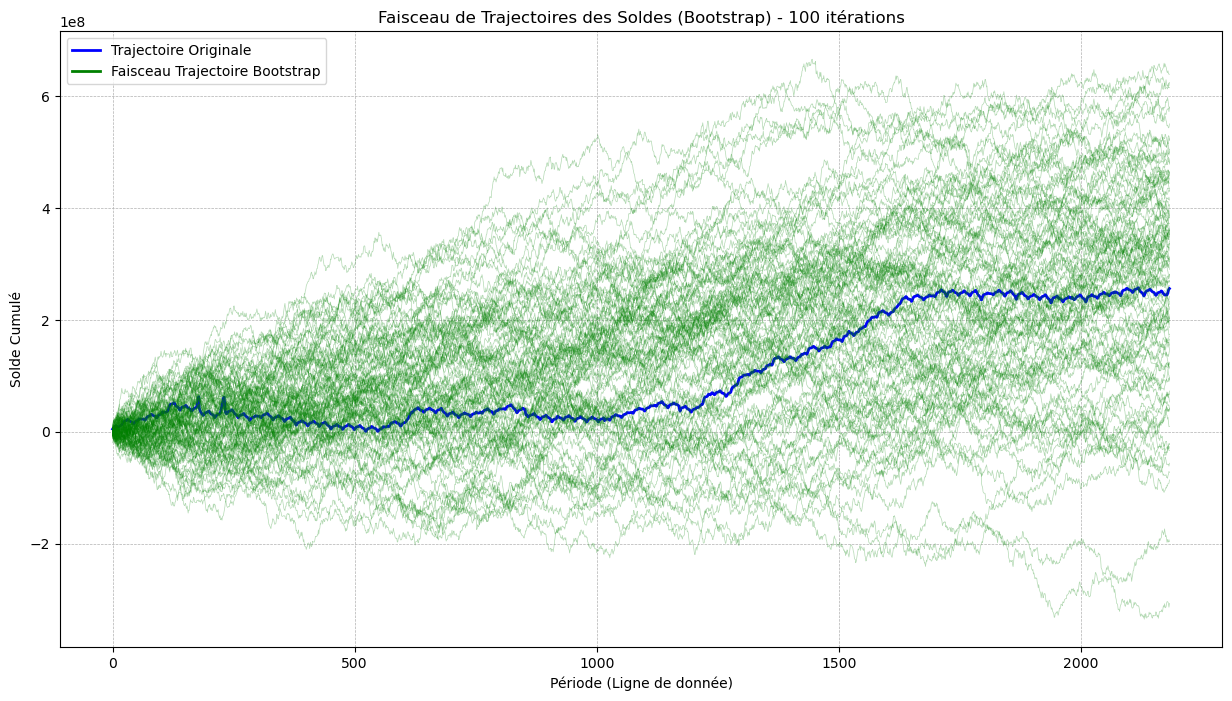

In [72]:
# Exemple d'appel pour sauvegarder les fichiers
#plot_simulation_trajecto('TABLE_LENDING_012020_032020.csv', 'recovery_summary_012020_032020 - Copie.csv', 'monte_carlo', 100)
plot_simulation_trajecto('TABLE_LENDING_012020_032020.csv', 'recovery_summary_012020_032020 - Copie.csv', 'bootstrap', 100)

Génération des simulations...
Visualisation des patterns temporels des emprunts:


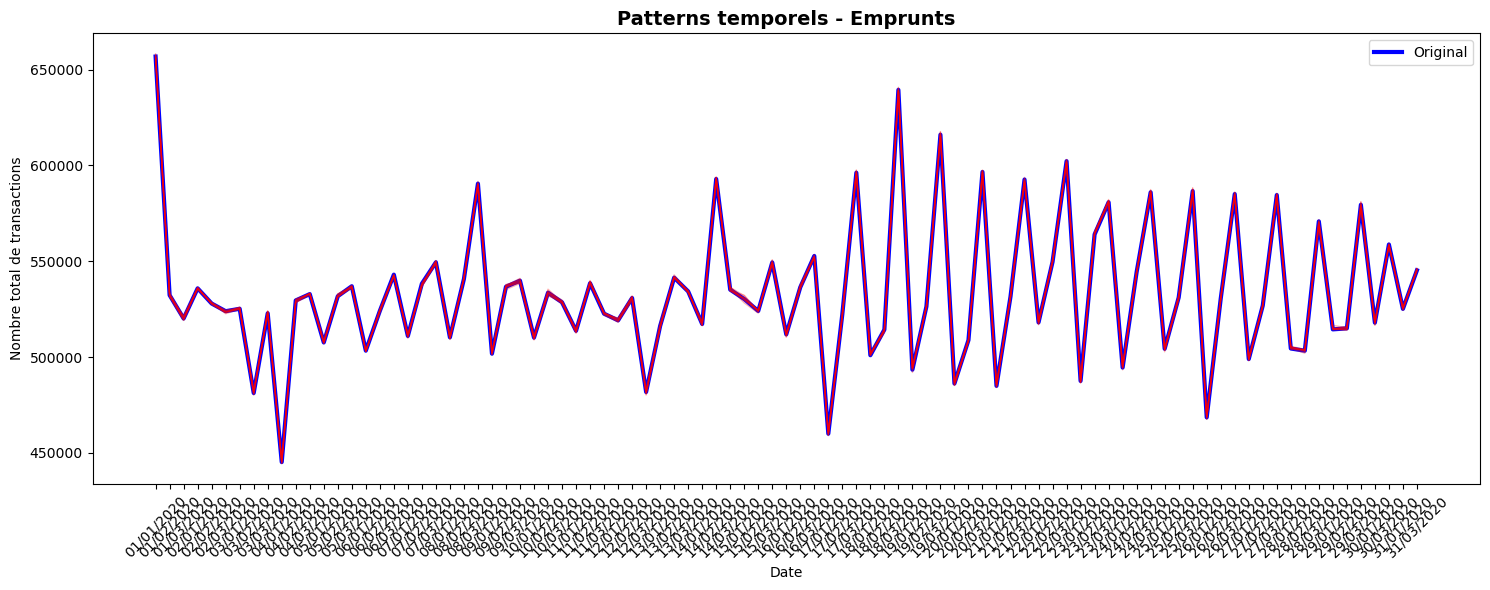

Visualisation des patterns temporels des remboursements:


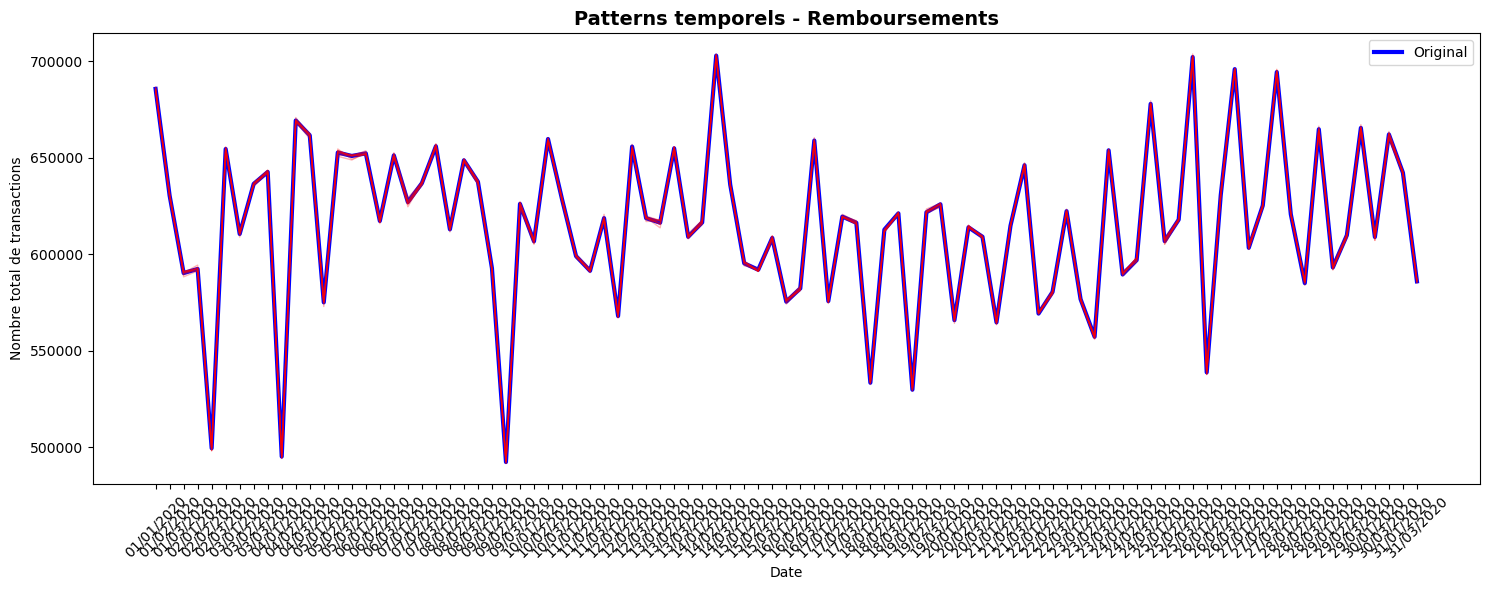

Tracé des trajectoires...


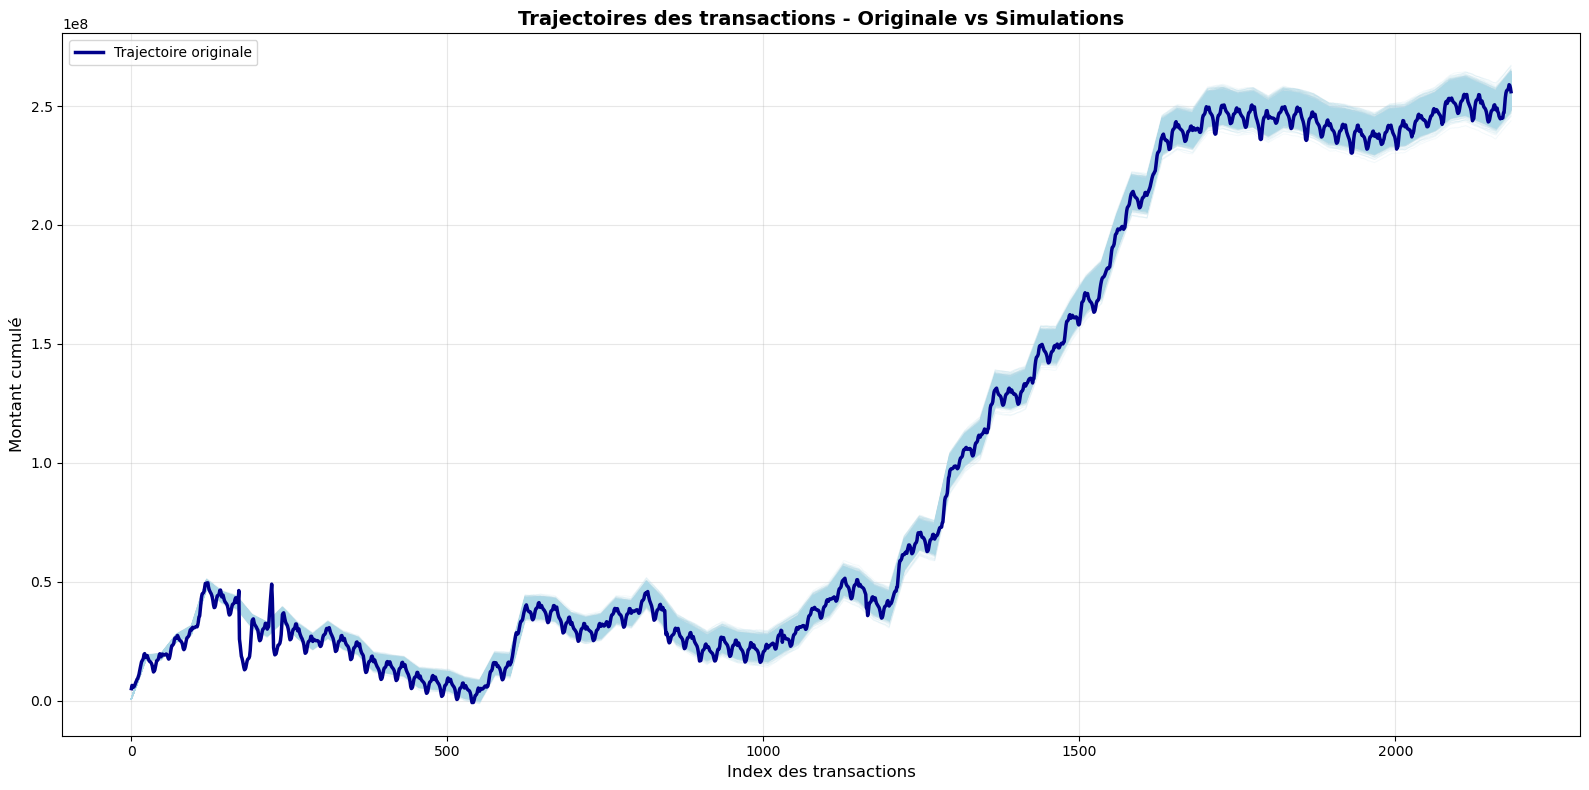

STATISTIQUES DES TRAJECTOIRES (avec structure temporelle)
Nombre de transactions originales: 2184
Nombre de simulations: 10000
Flux net total original: 256,056,707.00
Valeur cumulative finale originale: 256,056,707.00
Valeur cumulative moyenne des simulations: 256,024,073.06
Écart-type des valeurs finales: 2,905,526.13
Intervalle de confiance à 95%: [250,287,803.93, 261,768,615.10]


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration de l'affichage
plt.style.use('default')
sns.set_palette("husl")

def calculer_somme(df):
    """
    Calcule la somme pondérée des transactions en multipliant chaque cellule par l'en-tête de sa colonne
    """
    sommes = []
    colonnes_a_exclure = ['ref_date', 'interval', 'SDATE', 'INTERVAL', 'SUM_CENTS_PRINCIPAL']
    colonnes_numeriques = []
    
    for col in df.columns:
        if col not in colonnes_a_exclure:
            try:
                float(col)
                colonnes_numeriques.append(col)
            except ValueError:
                continue
    
    df_a_calculer = df[colonnes_numeriques]
    
    for index, ligne in df_a_calculer.iterrows(): 
        somme_ligne_actuelle = 0
        for nom_colonne, valeur_cellule in ligne.items():            
            try:
                valeur_entete = float(nom_colonne)
                valeur_numerique_cellule = float(valeur_cellule)
                somme_ligne_actuelle += valeur_entete * valeur_numerique_cellule
            except (ValueError, TypeError):
                continue
        sommes.append(somme_ligne_actuelle)
    
    return sommes

def load_and_preprocess_data(lending_file, recovery_file):
    """
    Charge et prétraite les données depuis les fichiers CSV
    """
    # Chargement des données
    lending_df = pd.read_csv(lending_file, sep=';')
    recovery_df = pd.read_csv(recovery_file, sep=';')
    
    # Nettoyage des noms de colonnes (supprimer les espaces)
    lending_df.columns = lending_df.columns.str.strip()
    recovery_df.columns = recovery_df.columns.str.strip()
    
    # Conversion des colonnes numériques
    numeric_cols_lending = [col for col in lending_df.columns if col not in ['ref_date', 'INTERVAL']]
    numeric_cols_recovery = [col for col in recovery_df.columns if col not in ['SDATE', 'INTERVAL']]
    
    for col in numeric_cols_lending:
        lending_df[col] = pd.to_numeric(lending_df[col], errors='coerce').fillna(0)
    
    for col in numeric_cols_recovery:
        recovery_df[col] = pd.to_numeric(recovery_df[col], errors='coerce').fillna(0)
    
    return lending_df, recovery_df

def calculate_cash_flow(lending_df, recovery_df):
    """
    Calcule le flux de trésorerie net à partir des données d'emprunts et de remboursements
    en utilisant la fonction calculer_somme personnalisée
    """
    # Calcul du montant total des emprunts par ligne
    lending_df['total_lending'] = calculer_somme(lending_df)
    
    # Calcul du montant total des remboursements par ligne
    recovery_df['total_recovery'] = calculer_somme(recovery_df)
    
    # Création d'un identifiant unique pour chaque ligne (date + intervalle)
    lending_df['datetime_id'] = lending_df['ref_date'] + '_' + lending_df['INTERVAL'].astype(str)
    recovery_df['datetime_id'] = recovery_df['SDATE'] + '_' + recovery_df['INTERVAL'].astype(str)
    
    # Fusion des données
    merged_df = pd.merge(lending_df[['datetime_id', 'total_lending']], 
                        recovery_df[['datetime_id', 'total_recovery']], 
                        on='datetime_id', how='outer').fillna(0)
    
    # Calcul du flux net (emprunts - remboursements)
    merged_df['net_flow'] = merged_df['total_lending'] - merged_df['total_recovery']
    
    # Tri par datetime_id (qui représente l'ordre chronologique)
    merged_df = merged_df.sort_values('datetime_id').reset_index(drop=True)
    
    # Calcul de la trajectoire cumulative
    merged_df['cumulative_flow'] = merged_df['net_flow'].cumsum()
    
    return merged_df

def montecarlo_ameliore(df: pd.DataFrame) -> pd.DataFrame:
    """
    Simulation Monte Carlo améliorée qui préserve la structure temporelle
    en travaillant par blocs de 24 heures (par date)
    """
    # Copie de la structure du DataFrame original
    data_final = df.copy()
    
    # Identifier les colonnes numériques (montants)
    date_col = 'ref_date' if 'ref_date' in df.columns else 'SDATE'
    colonnes_numeriques = [col for col in df.columns if col not in [date_col, 'INTERVAL']]
    
    # Groupement par date pour préserver la structure temporelle
    dates_uniques = df[date_col].unique()
    
    for date in dates_uniques:
        # Filtrer les données pour cette date
        mask = df[date_col] == date
        temp = df[mask].copy()
        
        # Pour chaque colonne numérique, simuler en préservant la tendance temporelle
        for col in colonnes_numeriques:
            # Obtenir les valeurs originales pour cette colonne et cette date
            valeurs_originales = temp[col].values
            
            # Calculer le lambda moyen pour cette colonne et cette date
            lambda_hat = np.mean(valeurs_originales)
            
            if lambda_hat > 0:
                # Simuler en préservant la variabilité relative entre les intervalles
                valeurs_simulees = np.random.poisson(lam=lambda_hat, size=len(valeurs_originales))
            else:
                valeurs_simulees = np.zeros_like(valeurs_originales)
            
            # Mettre à jour les valeurs dans le DataFrame final
            data_final.loc[mask, col] = valeurs_simulees
    
    return data_final

def bootstrap_ameliore(df: pd.DataFrame) -> pd.DataFrame:
    """
    Simulation Bootstrap améliorée qui préserve la structure temporelle
    en rééchantillonnant des blocs complets de 24 heures
    """
    # Copie de la structure du DataFrame original
    data_final = df.copy()
    
    # Identifier les colonnes numériques (montants)
    date_col = 'ref_date' if 'ref_date' in df.columns else 'SDATE'
    colonnes_numeriques = [col for col in df.columns if col not in [date_col, 'INTERVAL']]
    
    # Groupement par date pour préserver la structure temporelle
    dates_uniques = df[date_col].unique()
    
    # Créer une liste de toutes les dates disponibles pour le rééchantillonnage
    dates_disponibles = list(dates_uniques)
    
    for date in dates_uniques:
        # Rééchantillonner une date aléatoire (avec remise)
        date_echantillon = np.random.choice(dates_disponibles)
        
        # Filtrer les données originales pour la date échantillonnée
        mask_original = df[date_col] == date_echantillon
        mask_cible = df[date_col] == date
        
        donnees_echantillon = df[mask_original].copy()
        
        # Pour chaque colonne numérique, copier les valeurs de la date échantillonnée
        for col in colonnes_numeriques:
            data_final.loc[mask_cible, col] = donnees_echantillon[col].values
    
    return data_final

def generate_simulations_avance(original_lending, original_recovery, n_simulations=50, method='montecarlo'):
    """
    Génère des simulations avancées qui préservent la structure temporelle
    """
    simulated_lending_list = []
    simulated_recovery_list = []
    
    for i in range(n_simulations):
        if method == 'montecarlo':
            # Utiliser la version améliorée qui préserve la structure temporelle
            sim_lending = montecarlo_ameliore(original_lending)
            sim_recovery = montecarlo_ameliore(original_recovery)
        elif method == 'bootstrap':
            # Utiliser la version améliorée qui préserve la structure temporelle
            sim_lending = bootstrap_ameliore(original_lending)
            sim_recovery = bootstrap_ameliore(original_recovery)
        else:
            raise ValueError("Méthode doit être 'montecarlo' ou 'bootstrap'")
        
        simulated_lending_list.append(sim_lending)
        simulated_recovery_list.append(sim_recovery)
    
    return simulated_lending_list, simulated_recovery_list

def plot_transaction_trajectories(original_lending, original_recovery, 
                                 simulated_lending_list, simulated_recovery_list,
                                 original_color='darkblue', simulated_color='lightblue', 
                                 alpha=0.3, linewidth=0.8, figsize=(15, 8)):
    """
    Trace les trajectoires des transactions originales et simulées
    """
    # Calcul de la trajectoire originale
    original_flow = calculate_cash_flow(original_lending, original_recovery)
    
    # Calcul des trajectoires simulées
    simulated_flows = []
    for i in range(len(simulated_lending_list)):
        sim_flow = calculate_cash_flow(simulated_lending_list[i], simulated_recovery_list[i])
        simulated_flows.append(sim_flow)
    
    # Création de la figure
    plt.figure(figsize=figsize)
    
    # Tracer toutes les trajectoires simulées
    for i, sim_flow in enumerate(simulated_flows):
        plt.plot(sim_flow.index, sim_flow['cumulative_flow'], 
                color=simulated_color, alpha=alpha, linewidth=linewidth)
    
    # Tracer la trajectoire originale (plus épaisse et plus visible)
    plt.plot(original_flow.index, original_flow['cumulative_flow'], 
            color=original_color, linewidth=2.5, label='Trajectoire originale')
    
    # Configuration du graphique
    plt.xlabel('Index des transactions', fontsize=12)
    plt.ylabel('Montant cumulé', fontsize=12)
    plt.title('Trajectoires des transactions - Originale vs Simulations', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Améliorer l'apparence
    plt.tight_layout()
    plt.show()
    
    return original_flow, simulated_flows

# Fonction pour visualiser les patterns temporels
def visualize_temporal_patterns(original_df, simulated_dfs, title="Patterns temporels"):
    """
    Visualise les patterns temporels des données originales vs simulées
    """
    plt.figure(figsize=(15, 6))
    
    # Identifier la colonne de date
    date_col = 'ref_date' if 'ref_date' in original_df.columns else 'SDATE'
    
    # Calculer la somme quotidienne pour les données originales
    colonnes_numeriques = [col for col in original_df.columns if col not in [date_col, 'INTERVAL']]
    original_daily = original_df.groupby(date_col)[colonnes_numeriques].sum().sum(axis=1)
    
    plt.plot(original_daily.index, original_daily.values, 'b-', linewidth=3, label='Original')
    
    # Calculer et tracer les données simulées
    for i, sim_df in enumerate(simulated_dfs[:10]):  # Seulement les 10 premières pour la lisibilité
        sim_daily = sim_df.groupby(date_col)[colonnes_numeriques].sum().sum(axis=1)
        plt.plot(sim_daily.index, sim_daily.values, 'r-', alpha=0.3, linewidth=1)
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Nombre total de transactions')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation mise à jour
def main_ameliore():
    # Chemins des fichiers
    lending_file = "TABLE_LENDING_012020_032020.csv"
    recovery_file = "recovery_summary_012020_032020.csv"
    
    # Chargement des données originales
    lending_original, recovery_original = load_and_preprocess_data(lending_file, recovery_file)
    
    # Génération des simulations avec préservation de la structure temporelle
    n_simulations = 10000  # Commencez avec moins de simulations pour tester
    method = 'montecarlo'  # 'montecarlo' ou 'bootstrap'
    
    print("Génération des simulations...")
    simulated_lending_list, simulated_recovery_list = generate_simulations_avance(
        lending_original, recovery_original, n_simulations, method
    )
    
    # Visualiser les patterns temporels avant de tracer les trajectoires
    print("Visualisation des patterns temporels des emprunts:")
    visualize_temporal_patterns(lending_original, simulated_lending_list, "Patterns temporels - Emprunts")
    
    print("Visualisation des patterns temporels des remboursements:")
    visualize_temporal_patterns(recovery_original, simulated_recovery_list, "Patterns temporels - Remboursements")
    
    # Tracer les trajectoires cumulatives
    print("Tracé des trajectoires...")
    original_flow, simulated_flows = plot_transaction_trajectories(
        lending_original, recovery_original,
        simulated_lending_list, simulated_recovery_list,
        original_color='darkblue', 
        simulated_color='lightblue',
        alpha=0.15,
        linewidth=0.7,
        figsize=(16, 8)
    )
    
    # Statistiques descriptives
    print("=" * 60)
    print("STATISTIQUES DES TRAJECTOIRES (avec structure temporelle)")
    print("=" * 60)
    print(f"Nombre de transactions originales: {len(original_flow)}")
    print(f"Nombre de simulations: {len(simulated_flows)}")
    print(f"Flux net total original: {original_flow['net_flow'].sum():,.2f}")
    print(f"Valeur cumulative finale originale: {original_flow['cumulative_flow'].iloc[-1]:,.2f}")
    
    # Statistiques des simulations
    final_values = [flow['cumulative_flow'].iloc[-1] for flow in simulated_flows]
    print(f"Valeur cumulative moyenne des simulations: {np.mean(final_values):,.2f}")
    print(f"Écart-type des valeurs finales: {np.std(final_values):,.2f}")
    print(f"Intervalle de confiance à 95%: [{np.percentile(final_values, 2.5):,.2f}, {np.percentile(final_values, 97.5):,.2f}]")

# Exécution
if __name__ == "__main__":
    main_ameliore()

In [15]:
def estimation (file_lending: object, file_recovery: object, alpha = 0.95, N = 10000, method = "Montecarlo"):
    
    lending = pd.read_csv(file_lending, delimiter=';')
    recovery = pd.read_csv(file_recovery, delimiter=';')
    
    list_provision = []
    provisions = provision(lending, recovery)
    list_provision.append(provisions)

    
    if (method == "Montecarlo"):
        for i in tqdm(range(N)):
            temp_lending = montecarlo_ameliore(lending)
            temp_recovery = montecarlo_ameliore(recovery)
            provisions = provision(temp_lending, temp_recovery)
            list_provision.append(provisions)
            df_provisions = pd.DataFrame(list_provision, columns=['Montant_Provision_montecarlo'])
            df_provisions.to_csv('provisions_montecarlo.csv', index=False, sep=';')
            

    elif (method == "Bootstrap"):
        for i in tqdm(range(N)):
            temp_lending = bootstrap_ameliore(lending)
            temp_recovery = bootstrap_ameliore(recovery)
            provisions = provision(temp_lending, temp_recovery)
            list_provision.append(provisions)
            df_provisions = pd.DataFrame(list_provision, columns=['Montant_Provision_bootstrap'])
            df_provisions.to_csv('provisions_bootstrap.csv', index=False, sep=';')
    
    return list_provision

In [22]:
import pandas as pd
lending_file = "TABLE_LENDING_012020_032020.csv"
recovery_file = "recovery_summary_012020_032020.csv"
provisions_mc_ameliore = estimation(lending_file, recovery_file, N= 50)
df_montecarlo = pd.read_csv("provisions_montecarlo.csv")
provisions_mc_ameliore = df_montecarlo.to_numpy()
def clean(data):
    lower_bound = np.percentile(data, 1)
    upper_bound = np.percentile(data, 99)
    
    cleaned_data = data[(data >= lower_bound) & (data <= upper_bound)]
    return cleaned_data
provisions_mc_cleaned_ameliore = clean(provisions_mc_ameliore)

100%|██████████| 50/50 [01:09<00:00,  1.40s/it]


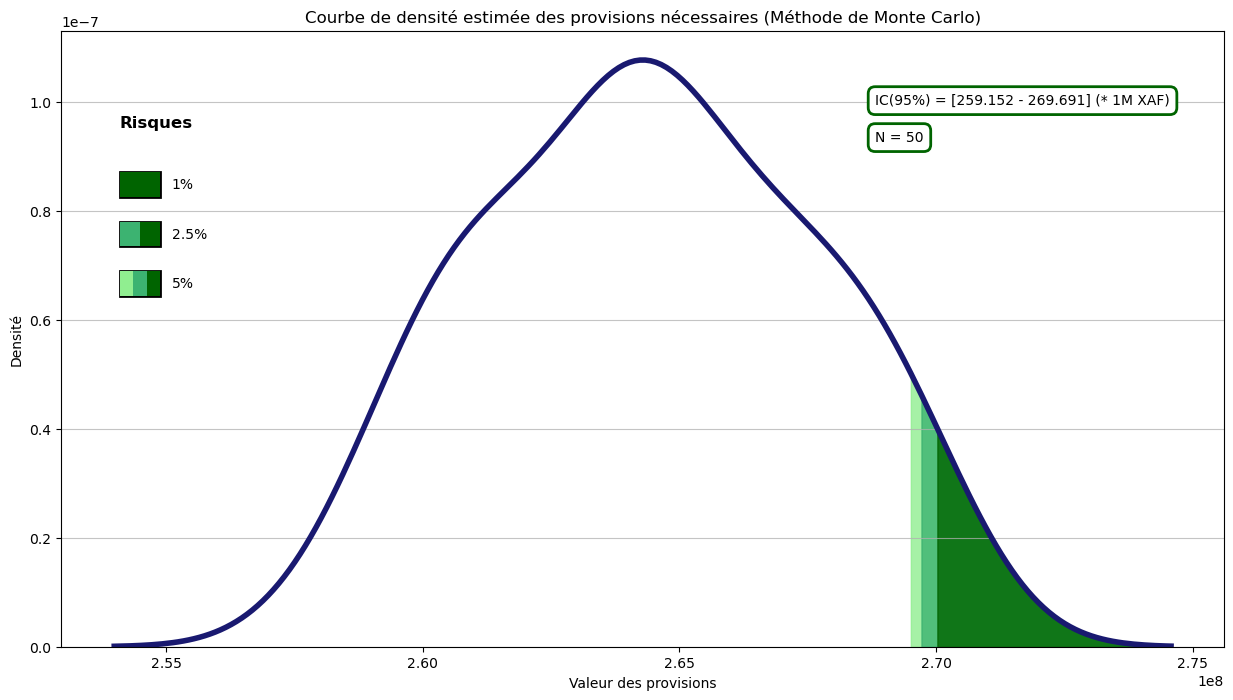

In [24]:
# --- Calcul des percentiles ---
p95 = np.percentile(provisions_mc_cleaned_ameliore, 95)
p97_5 = np.percentile(provisions_mc_cleaned_ameliore, 97.5)
p99 = np.percentile(provisions_mc_cleaned_ameliore, 99)
p2_5 = np.percentile(provisions_mc_cleaned_ameliore, 2.5)

# --- Calcul de l'intervalle de confiance et de N ---
p97_5_ic = np.percentile(provisions_mc_cleaned_ameliore, 97.5)
nombre_iterations = len(provisions_mc_ameliore) - 1
IC_value_low = p2_5 / 1000000
IC_value_high = p97_5_ic / 1000000

# --- Couleurs pour le graphique ---
couleur_verte_claire = '#90EE90'  # LightGreen
couleur_verte_moyenne = '#3CB371'  # MediumSeaGreen
couleur_verte_foncee = '#006400'  # DarkGreen
couleur_courbe = '#191970'        # Couleur de la courbe de densité

# Création d'une figure et d'un axe pour le tracé principal
fig, ax = plt.subplots(figsize=(15, 8))

# Tracé de la courbe de densité
sns.kdeplot(provisions_mc_cleaned_ameliore, color=couleur_courbe, linewidth=4, fill=False, ax=ax)

# Récupération des données de la courbe pour le remplissage
x_data, y_data = ax.get_lines()[0].get_xdata(), ax.get_lines()[0].get_ydata()

# Remplissage des zones de risque (avec superposition pour la continuité)
ax.fill_between(x_data, 0, y_data, where=(x_data >= p95), color=couleur_verte_claire, alpha=0.8)
ax.fill_between(x_data, 0, y_data, where=(x_data >= p97_5), color=couleur_verte_moyenne, alpha=0.8)
ax.fill_between(x_data, 0, y_data, where=(x_data >= p99), color=couleur_verte_foncee, alpha=0.8)

# Personnalisation du graphique
ax.set_title('Courbe de densité estimée des provisions nécessaires (Méthode de Monte Carlo)')
ax.set_xlabel('Valeur des provisions')
ax.set_ylabel('Densité')
ax.grid(axis='y', alpha=0.75)

# --- Modifications pour la légende des risques ---

# Coordonnées du bloc de légende (ajustez si besoin)
x_legend_pos = 0.05
y_legend_start_pos = 0.85
y_spacing = 0.08

# Titre pour la légende des risques
ax.text(x_legend_pos, y_legend_start_pos, 'Risques', transform=ax.transAxes, fontsize=12, weight='bold', ha='left', va='center')

# Fonction pour créer une légende (rectangle + texte)
def create_legend_box(ax, x_pos, y_pos, colors, label):
    
    # Dimensions du rectangle de fond
    rect_width = 0.035
    rect_height = 0.04
    
    # Création du rectangle de fond avec la bordure
    background_rect = Rectangle((x_pos, y_pos), rect_width, rect_height, 
                                transform=ax.transAxes, facecolor='white', edgecolor='black', lw=2, clip_on=False)
    ax.add_patch(background_rect)
    
    # Remplissage des couleurs à l'intérieur, parfaitement collées
    color_width = rect_width / len(colors)
    for i, color in enumerate(colors):
        color_rect = Rectangle((x_pos + i * color_width, y_pos), color_width, rect_height, 
                               transform=ax.transAxes, facecolor=color, lw=0, clip_on=False)
        ax.add_patch(color_rect)
        
    # Ajout du texte juste après le rectangle
    text_pos_x = x_pos + rect_width + 0.01 
    ax.text(text_pos_x, y_pos + rect_height / 2, label, transform=ax.transAxes, fontsize=10, va='center', ha='left')

# Appel de la fonction pour chaque risque
create_legend_box(ax, x_legend_pos, y_legend_start_pos - y_spacing * 1.5, [couleur_verte_foncee], '1%')
create_legend_box(ax, x_legend_pos, y_legend_start_pos - y_spacing * 2.5, [couleur_verte_moyenne, couleur_verte_foncee], '2.5%')
create_legend_box(ax, x_legend_pos, y_legend_start_pos - y_spacing * 3.5, [couleur_verte_claire, couleur_verte_moyenne, couleur_verte_foncee], '5%')


# --- Ajout de l'intervalle de confiance et de N ---
ax.text(0.70, 0.88, f"IC(95%) = [{IC_value_low:.3f} - {IC_value_high:.3f}] (* 1M XAF)",
        transform=ax.transAxes, fontsize=10, bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='darkgreen', lw=2))

ax.text(0.70, 0.82, f"N = {nombre_iterations}",
        transform=ax.transAxes, fontsize=10, bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='darkgreen', lw=2))

#plt.savefig("provision_montecarlo.png")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration de l'affichage
plt.style.use('default')
sns.set_palette("husl")

# Import des fonctions externes (elles doivent être définies dans d'autres cellules)
# from mon_module import calculer_somme, montecarlo_ameliore, bootstrap_ameliore

def load_and_preprocess_data(lending_file, recovery_file):
    """
    Charge et prétraite les données depuis les fichiers CSV
    """
    # Chargement des données
    lending_df = pd.read_csv(lending_file, sep=';')
    recovery_df = pd.read_csv(recovery_file, sep=';')
    
    # Nettoyage des noms de colonnes (supprimer les espaces)
    lending_df.columns = lending_df.columns.str.strip()
    recovery_df.columns = recovery_df.columns.str.strip()
    
    # Conversion des colonnes numériques
    numeric_cols_lending = [col for col in lending_df.columns if col not in ['ref_date', 'INTERVAL']]
    numeric_cols_recovery = [col for col in recovery_df.columns if col not in ['SDATE', 'INTERVAL']]
    
    for col in numeric_cols_lending:
        lending_df[col] = pd.to_numeric(lending_df[col], errors='coerce').fillna(0)
    
    for col in numeric_cols_recovery:
        recovery_df[col] = pd.to_numeric(recovery_df[col], errors='coerce').fillna(0)
    
    return lending_df, recovery_df

def calculate_cash_flow(lending_df, recovery_df, calculer_somme):
    """
    Calcule le flux de trésorerie net à partir des données d'emprunts et de remboursements
    en utilisant la fonction calculer_somme externe
    """
    # Calcul du montant total des emprunts par ligne
    lending_df['total_lending'] = calculer_somme(lending_df)
    
    # Calcul du montant total des remboursements par ligne
    recovery_df['total_recovery'] = calculer_somme(recovery_df)
    
    # Création d'un identifiant unique pour chaque ligne (date + intervalle)
    lending_df['datetime_id'] = lending_df['ref_date'] + '_' + lending_df['INTERVAL'].astype(str)
    recovery_df['datetime_id'] = recovery_df['SDATE'] + '_' + recovery_df['INTERVAL'].astype(str)
    
    # Fusion des données
    merged_df = pd.merge(lending_df[['datetime_id', 'total_lending']], 
                        recovery_df[['datetime_id', 'total_recovery']], 
                        on='datetime_id', how='outer').fillna(0)
    
    # Calcul du flux net (emprunts - remboursements)
    merged_df['net_flow'] = merged_df['total_lending'] - merged_df['total_recovery']
    
    # Tri par datetime_id (qui représente l'ordre chronologique)
    merged_df = merged_df.sort_values('datetime_id').reset_index(drop=True)
    
    # Calcul de la trajectoire cumulative
    merged_df['cumulative_flow'] = merged_df['net_flow'].cumsum()
    
    return merged_df

def generate_and_plot_realtime(original_lending, original_recovery, calculer_somme, 
                              montecarlo_ameliore, bootstrap_ameliore, 
                              n_simulations=10000, method='montecarlo', 
                              original_color='darkblue', simulated_color='lightcoral',
                              alpha=0.15, linewidth=0.7, figsize=(16, 8)):
    """
    Génère des simulations et trace les trajectoires en temps réel
    """
    # Configuration de la figure pour le tracé en temps réel
    plt.figure(figsize=figsize)
    
    # Calcul de la trajectoire originale
    original_flow = calculate_cash_flow(original_lending.copy(), original_recovery.copy(), calculer_somme)
    
    # Tracer la trajectoire originale
    plt.plot(original_flow.index, original_flow['cumulative_flow'], 
             color=original_color, linewidth=2.5, label='Trajectoire originale')
    
    # Initialiser les listes pour stocker les résultats
    simulated_flows = []
    
    # Boucle de simulation en temps réel
    for i in range(n_simulations):
        # Générer une simulation
        if method == 'montecarlo':
            sim_lending = montecarlo_ameliore(original_lending)
            sim_recovery = montecarlo_ameliore(original_recovery)
        elif method == 'bootstrap':
            sim_lending = bootstrap_ameliore(original_lending)
            sim_recovery = bootstrap_ameliore(original_recovery)
        else:
            raise ValueError("Méthode doit être 'montecarlo' ou 'bootstrap'")
        
        # Calculer le flux de trésorerie pour cette simulation
        sim_flow = calculate_cash_flow(sim_lending, sim_recovery, calculer_somme)
        simulated_flows.append(sim_flow)
        
        # Tracer cette simulation en temps réel
        plt.plot(sim_flow.index, sim_flow['cumulative_flow'], 
                 color=simulated_color, alpha=alpha, linewidth=linewidth)
        
        # Mettre à jour l'affichage après chaque simulation
        plt.draw()
        plt.pause(0.01)  # Pause courte pour permettre la mise à jour
        
        # Afficher la progression
        print(f"Simulation {i+1}/{n_simulations} terminée")
    
    # Configuration finale du graphique
    plt.xlabel('Index des transactions', fontsize=12)
    plt.ylabel('Montant cumulé', fontsize=12)
    plt.title(f'Trajectoires des transactions - {n_simulations} simulations {method}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    
    # Afficher le graphique final
    plt.show()
    
    return original_flow, simulated_flows

def plot_final_statistics(original_flow, simulated_flows):
    """
    Affiche les statistiques finales après toutes les simulations
    """
    # Statistiques descriptives
    print("=" * 60)
    print("STATISTIQUES DES TRAJECTOIRES")
    print("=" * 60)
    print(f"Nombre de transactions originales: {len(original_flow)}")
    print(f"Nombre de simulations: {len(simulated_flows)}")
    print(f"Flux net total original: {original_flow['net_flow'].sum():,.2f}")
    print(f"Valeur cumulative finale originale: {original_flow['cumulative_flow'].iloc[-1]:,.2f}")
    
    # Statistiques des simulations
    final_values = [flow['cumulative_flow'].iloc[-1] for flow in simulated_flows]
    print(f"Valeur cumulative moyenne des simulations: {np.mean(final_values):,.2f}")
    print(f"Écart-type des valeurs finales: {np.std(final_values):,.2f}")
    print(f"Intervalle de confiance à 95%: [{np.percentile(final_values, 2.5):,.2f}, {np.percentile(final_values, 97.5):,.2f}]")
    
    # Tracer un histogramme des valeurs finales
    plt.figure(figsize=(10, 6))
    plt.hist(final_values, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(np.mean(final_values), color='red', linestyle='dashed', linewidth=2, label=f'Moyenne: {np.mean(final_values):.2f}')
    plt.axvline(original_flow['cumulative_flow'].iloc[-1], color='green', linestyle='dashed', linewidth=2, label=f'Original: {original_flow["cumulative_flow"].iloc[-1]:.2f}')
    plt.xlabel('Valeur cumulative finale')
    plt.ylabel('Fréquence')
    plt.title('Distribution des valeurs finales des simulations')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Fonction principale
def main_realtime_trajectories(calculer_somme, montecarlo_ameliore, bootstrap_ameliore):
    """
    Fonction principale pour exécuter les simulations et tracés en temps réel
    """
    # Chemins des fichiers
    lending_file = "TABLE_LENDING_012020_032020.csv"
    recovery_file = "recovery_summary_012020_032020.csv"
    
    # Chargement des données originales
    print("Chargement des données...")
    lending_original, recovery_original = load_and_preprocess_data(lending_file, recovery_file)
    
    # Paramètres des simulations
    n_simulations = 50  # Nombre de simulations
    method = 'montecarlo'  # 'montecarlo' ou 'bootstrap'
    
    print(f"Début des simulations {method} avec {n_simulations} itérations...")
    
    # Génération et tracé en temps réel
    original_flow, simulated_flows = generate_and_plot_realtime(
        lending_original, recovery_original, calculer_somme,
        montecarlo_ameliore, bootstrap_ameliore,
        n_simulations=n_simulations,
        method=method
    )
    
    # Affichage des statistiques finales
    plot_final_statistics(original_flow, simulated_flows)
    
    return original_flow, simulated_flows

# Exécution
if __name__ == "__main__":
    # Assurez-vous que ces fonctions sont définies dans votre notebook
    # calculer_somme, montecarlo_ameliore, bootstrap_ameliore
    
    # Exécuter la simulation en temps réel
    original_flow, simulated_flows = main_realtime_trajectories(
        calculer_somme, montecarlo_ameliore, bootstrap_ameliore
    )

Chargement des données...
Début des simulations montecarlo avec 50 itérations...


Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq\\backend\\cython\\checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt: 
